In [1]:
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os

from model.net import *
from utils.training import *
from data.data import *

## Experiment Config

In [2]:
model_path = os.path.join(os.getcwd(), "weights")

args = {
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 256,
    'N_EPOCHS': 30,
    'LEARNING_RATE': 0.01,
    'MOMENTUM': 0.9,
    'DATASET_NAME':'mnist',
    'LAMBDA_recon': 1, #0.0005
    'LAMBDA_margin': 0,
    'LReLU_negative_slope':0.1,
}

## Model Loading

In [3]:
#Modified Reconstructor

class Reconstructor(nn.Module):
    def __init__(self, net):
        super(Reconstructor, self).__init__()
        self.input_width = net.decoder.input_width
        self.input_height = net.decoder.input_height
        self.input_channel = net.decoder.input_channel
        self.reconstraction_layers = net.decoder.reconstraction_layers
        self.mean = torch.tensor(0.1307)
        self.std = torch.tensor(0.3081)
        if(args['USE_CUDA']):
            self.mean = self.mean.cuda()
            self.std = self.std.cuda()
        self.unnormalize = UnNormalize(self.mean, self.std)
        
#     def forward(self, x, data):
# #         classes = torch.sqrt((x ** 2).sum(2))
# #         classes = F.softmax(classes.squeeze(), dim=1)
# #         _, max_length_indices = classes.max(dim=1)
#         eye = torch.sparse.torch.eye(10)
#         if USE_CUDA:
#             eye = eye.cuda()
#         reconstructions_of_digits = []
#         for i in range(0,x.size(1)):
#             index_list = torch.ones((x.size(0), ),dtype=torch.int64).cuda()*i
#             masked = eye.index_select(dim=0, index=index_list)
#             reconstructions_of_digits.append(self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), 1, -1)))
        
#         reconstructions_of_digits = torch.cat(reconstructions_of_digits, dim=1) #shape = [B, 10, 28*28*1]
#         expanded_data = data.view(x.size(0), 1, -1).expand(-1, 10, -1)
#         unnormalized_data = self.unnormalize(expanded_data)
#         l2_distances = torch.square((unnormalized_data - reconstructions_of_digits)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
# #         reconstructions = reconstructions.view(-1, x.size(1), self.input_channel, self.input_width, self.input_height)
#         return l2_distances

    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes.squeeze(), dim=1)
        _, max_length_indices = classes.max(dim=1)
        max_length_indices_2 = 9 - max_length_indices
        eye = torch.sparse.torch.eye(10)
        if USE_CUDA:
            eye = eye.cuda()
        reconstructions_of_digits = []
        list_of_indices = [max_length_indices, max_length_indices_2]
        for i, index_list in enumerate(list_of_indices):#, max_length_indices_2]:
            masked = eye.index_select(dim=0, index=index_list.squeeze().data)
#             breakpoint()
            reconstructions_of_digits.append(self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), 1, -1)))

        reconstructions_of_digits = torch.cat(reconstructions_of_digits, dim=1) #shape = [B, 2, 28*28*1]
        expanded_data = data.view(x.size(0), 1, -1).expand(-1, len(list_of_indices), -1)
        unnormalized_data = self.unnormalize(expanded_data)
        img1 = data[0].reshape(28,28)
        img2 = reconstructions_of_digits[0][0].reshape(28, 28)
        img3 = reconstructions_of_digits[0][1].reshape(28, 28)
        imshow(img1)
        imshow(img2)
        imshow(img3)
        l2_distances = torch.square((unnormalized_data - reconstructions_of_digits)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
        return l2_distances
    
def imshow(img):
#     img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.cpu().numpy()
#     plt.imshow(np.transpose(npimg)#, (1, 2, 0)))
    plt.imshow(npimg)
    plt.show()

In [4]:
class Config:
    def __init__(self, dataset='mnist'):
        # CNN (cnn)
        self.cnn_in_channels = 1
        self.cnn_out_channels = 12
        self.cnn_kernel_size = 15

        # Primary Capsule (pc)
        self.pc_num_capsules = 1
        self.pc_in_channels = 12
        self.pc_out_channels = 16
        self.pc_kernel_size = 8
        self.pc_num_routes = 1 * 7 * 7

        # Digit Capsule 1 (dc)
        self.dc_num_capsules = 49
        self.dc_num_routes = 7 * 7 #7*7*16
        self.dc_in_channels = 16
        self.dc_out_channels = 16 #1
        
        # Digit Capsule 2 (dc)
        self.dc_2_num_capsules = 10
        self.dc_2_num_routes = 7 * 7
        self.dc_2_in_channels = 16 #1
        self.dc_2_out_channels = 16

        # Decoder
        self.input_width = 28
        self.input_height = 28
torch.manual_seed(1)
config = Config()

net = CapsNet(args, config)
# capsule_net = torch.nn.DataParallel(capsule_net)
if args['USE_CUDA']:
    net = net.cuda()
    
net.load_state_dict(torch.load(os.path.join(model_path, 'CapsNetMNIST_Recon_model2_iter2.pth'), map_location='cpu'))

<All keys matched successfully>

## Loading Dataset

In [5]:
trainloader, testloader = dataset(args)

##  The histogram of L2 distances between the input and the reconstruction using the
## correct capsule or other capsules in CapsNet on the real MNIST images. 

In [6]:
import matplotlib.pyplot as plt

def L2_Cor_Incor_Capsules(model, reconstructor, train_loader, args):
    net = model
    net.eval()
    n_batch = len(train_loader)
    l2_distances = []
    with torch.no_grad():
        for batch_id, (data, target) in enumerate(tqdm(train_loader)):
            if(args['USE_CUDA']):
                data = data.cuda()

            output, _, _ = net(data)
            l2_distances.append(reconstructor(output, data).view(-1, ))
    
    return torch.cat(l2_distances, dim=0).cpu().numpy()

def plot_hist(l2_distances, num_bins=140):
    fig, ax = plt.subplots()

    # the histogram of the data
    n, bins, patches = ax.hist(l2_distances, num_bins)

    ax.set_xlabel('l2_distances')
    ax.set_ylabel('Samples')
    ax.set_title('L2 Distances input and recons')

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()

  0%|          | 0/235 [00:00<?, ?it/s]

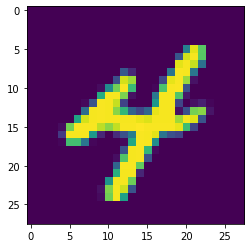

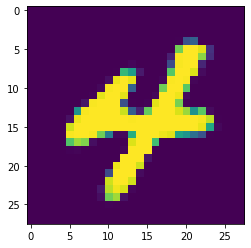

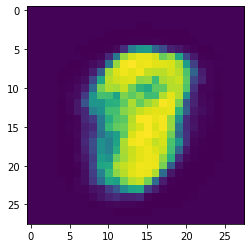

  0%|          | 1/235 [00:01<04:14,  1.09s/it]

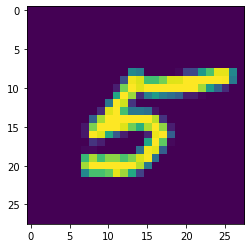

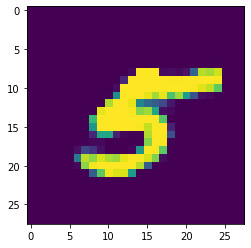

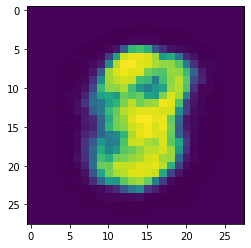

  1%|          | 2/235 [00:01<03:26,  1.13it/s]

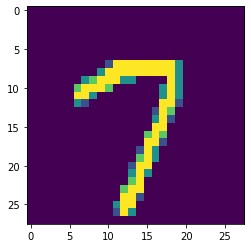

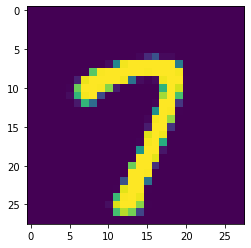

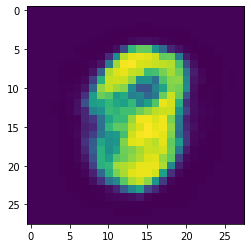

  1%|▏         | 3/235 [00:01<02:50,  1.36it/s]

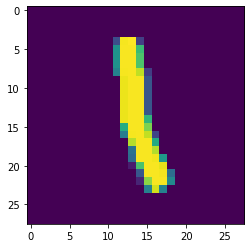

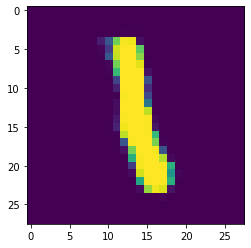

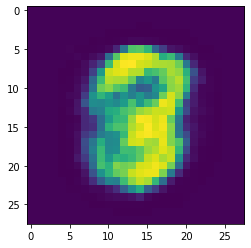

  2%|▏         | 4/235 [00:02<02:24,  1.60it/s]

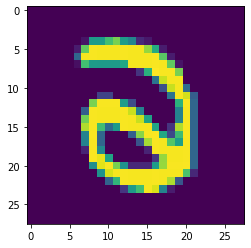

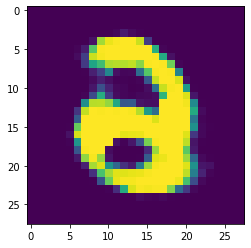

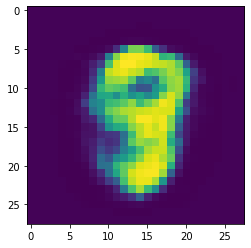

  2%|▏         | 5/235 [00:02<02:06,  1.81it/s]

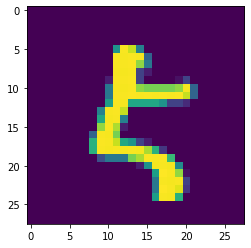

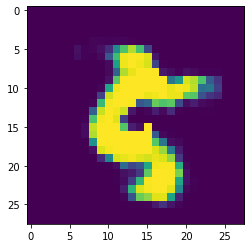

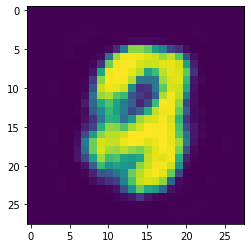

  3%|▎         | 6/235 [00:03<01:56,  1.96it/s]

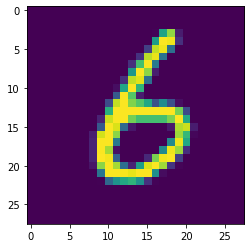

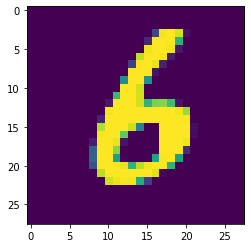

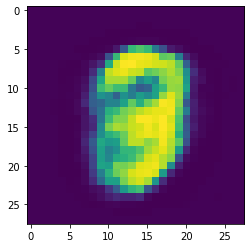

  3%|▎         | 7/235 [00:03<01:47,  2.13it/s]

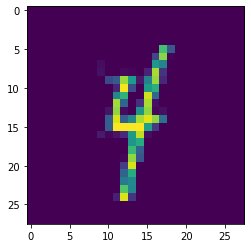

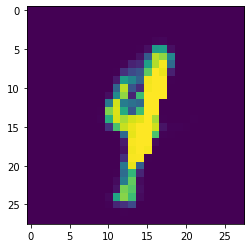

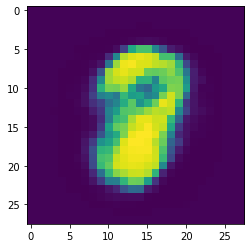

  3%|▎         | 8/235 [00:03<01:40,  2.26it/s]

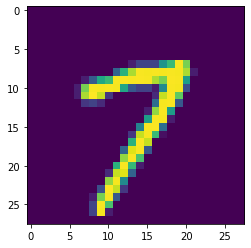

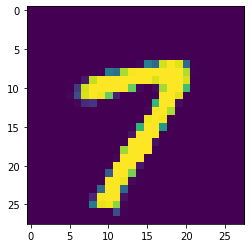

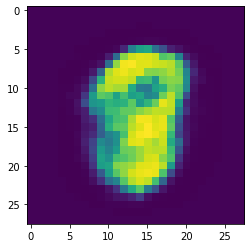

  4%|▍         | 9/235 [00:04<01:35,  2.37it/s]

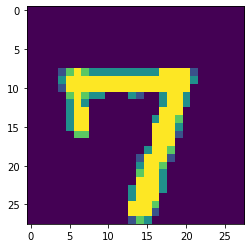

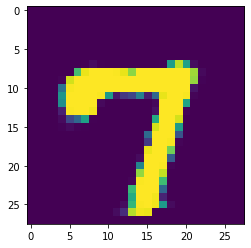

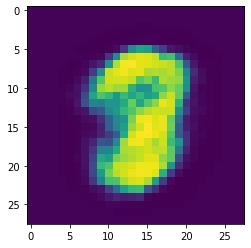

  4%|▍         | 10/235 [00:04<01:34,  2.38it/s]

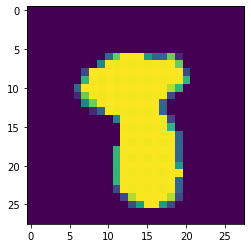

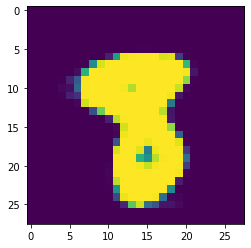

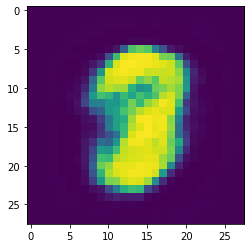

  5%|▍         | 11/235 [00:04<01:31,  2.46it/s]

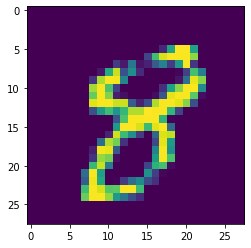

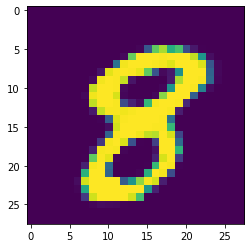

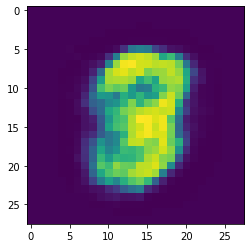

  5%|▌         | 12/235 [00:05<01:28,  2.51it/s]

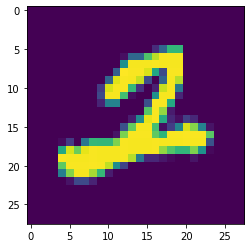

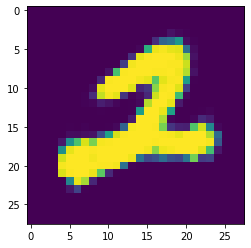

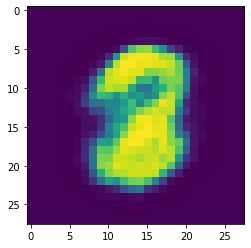

  6%|▌         | 13/235 [00:05<01:26,  2.56it/s]

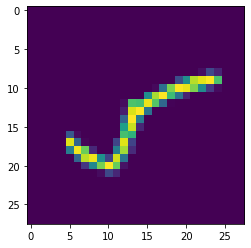

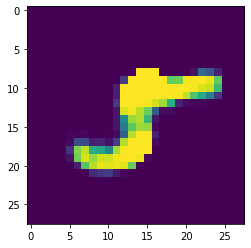

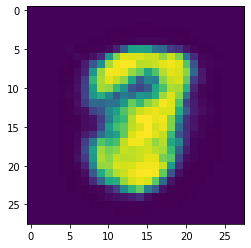

  6%|▌         | 14/235 [00:06<01:28,  2.51it/s]

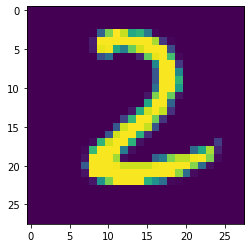

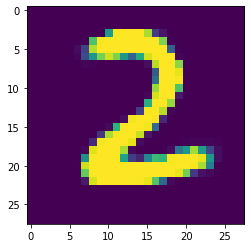

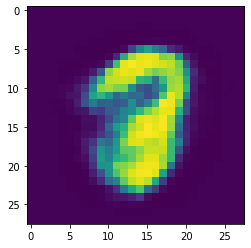

  6%|▋         | 15/235 [00:06<01:26,  2.55it/s]

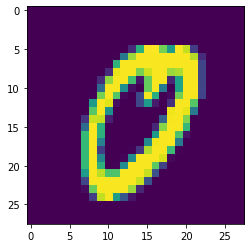

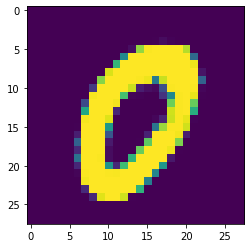

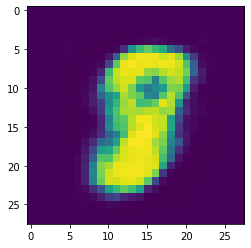

  7%|▋         | 16/235 [00:06<01:24,  2.59it/s]

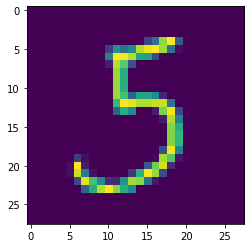

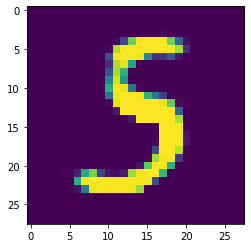

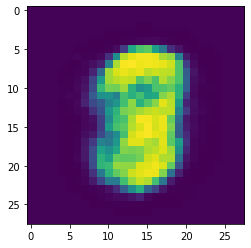

  7%|▋         | 17/235 [00:07<01:23,  2.61it/s]

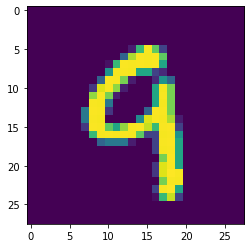

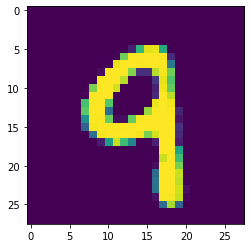

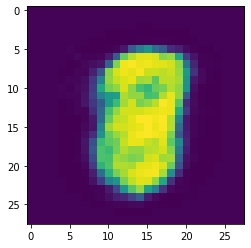

  8%|▊         | 18/235 [00:07<01:25,  2.54it/s]

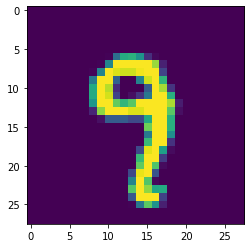

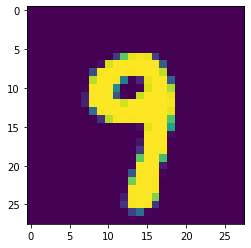

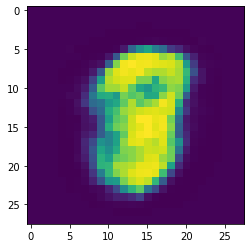

  8%|▊         | 19/235 [00:08<01:23,  2.58it/s]

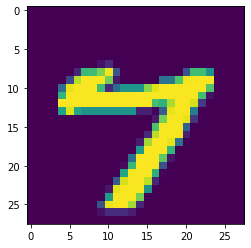

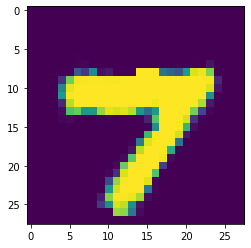

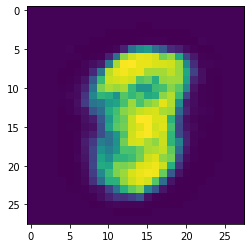

  9%|▊         | 20/235 [00:08<01:22,  2.60it/s]

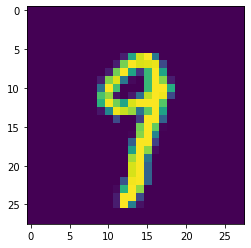

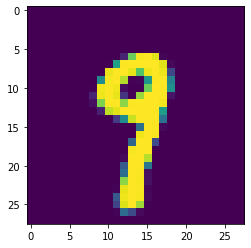

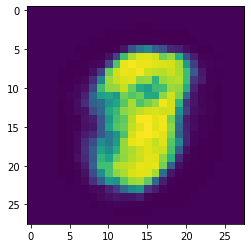

  9%|▉         | 21/235 [00:08<01:21,  2.62it/s]

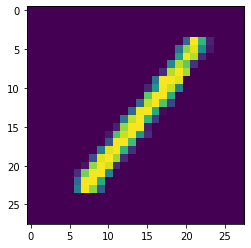

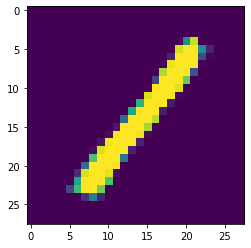

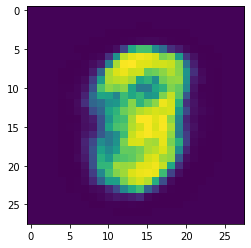

  9%|▉         | 22/235 [00:09<01:23,  2.55it/s]

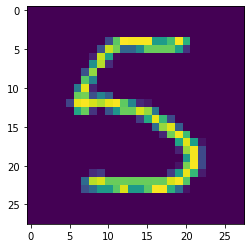

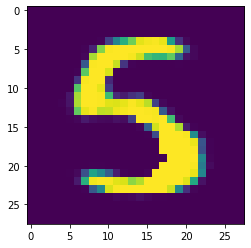

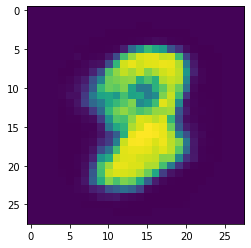

 10%|▉         | 23/235 [00:09<01:21,  2.59it/s]

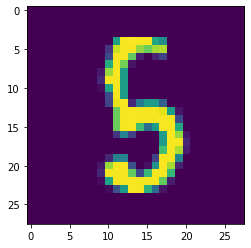

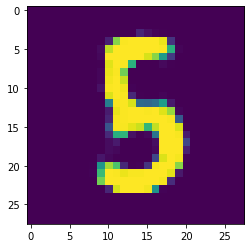

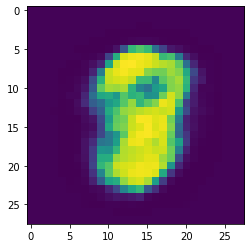

 10%|█         | 24/235 [00:09<01:20,  2.61it/s]

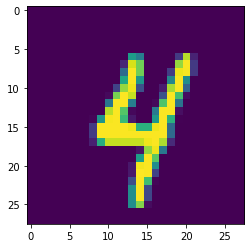

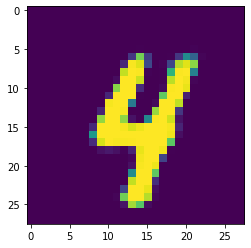

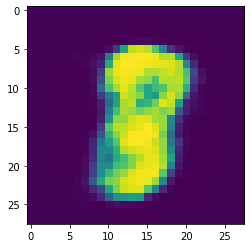

 11%|█         | 25/235 [00:10<01:19,  2.63it/s]

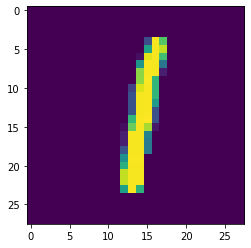

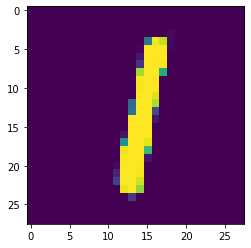

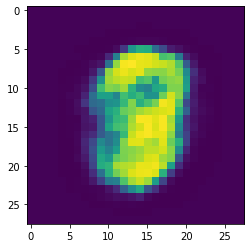

 11%|█         | 26/235 [00:10<01:21,  2.56it/s]

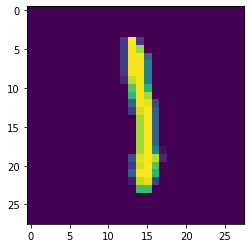

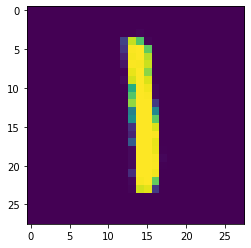

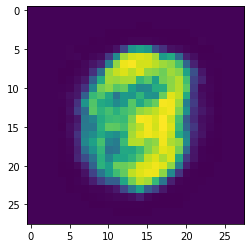

 11%|█▏        | 27/235 [00:11<01:20,  2.59it/s]

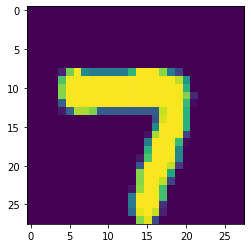

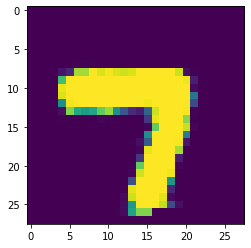

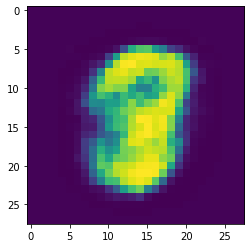

 12%|█▏        | 28/235 [00:11<01:19,  2.61it/s]

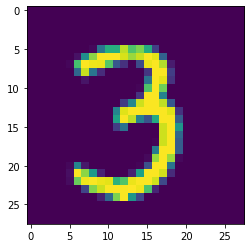

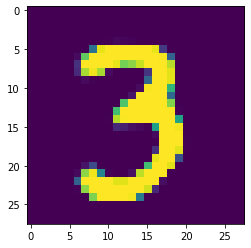

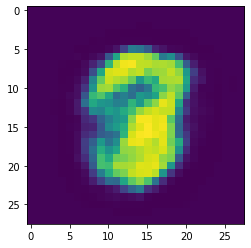

 12%|█▏        | 29/235 [00:11<01:18,  2.62it/s]

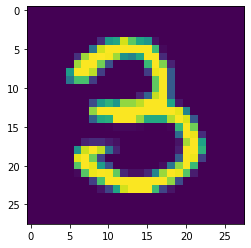

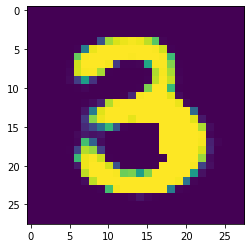

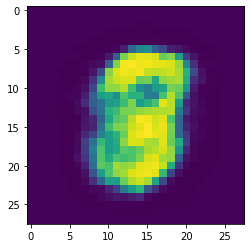

 13%|█▎        | 30/235 [00:12<01:20,  2.55it/s]

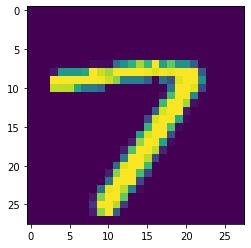

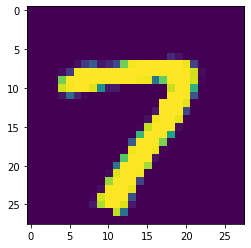

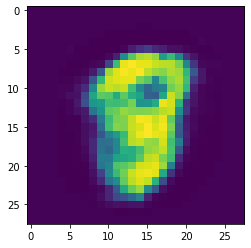

 13%|█▎        | 31/235 [00:12<01:18,  2.59it/s]

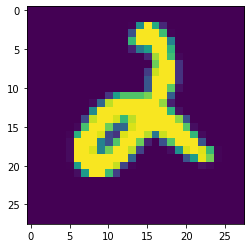

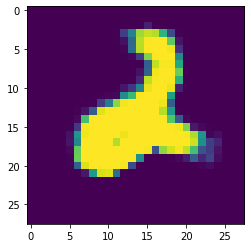

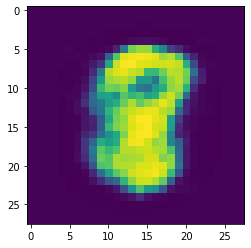

 14%|█▎        | 32/235 [00:13<01:17,  2.61it/s]

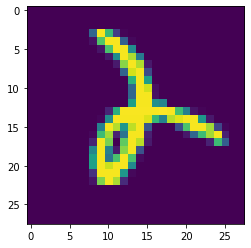

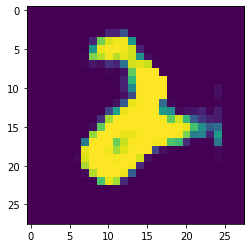

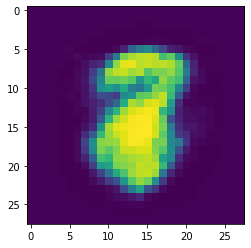

 14%|█▍        | 33/235 [00:13<01:17,  2.62it/s]

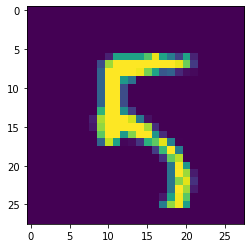

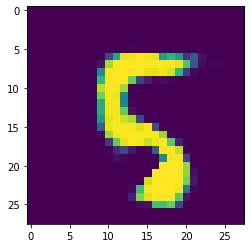

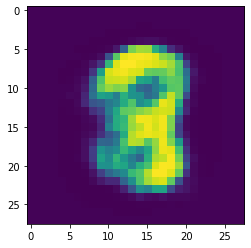

 14%|█▍        | 34/235 [00:13<01:18,  2.56it/s]

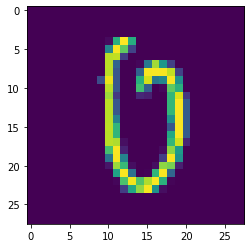

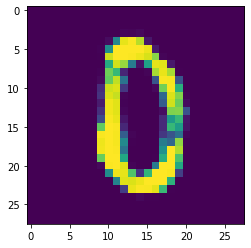

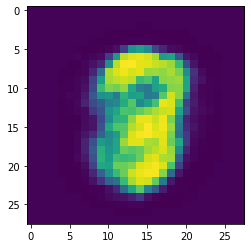

 15%|█▍        | 35/235 [00:14<01:17,  2.59it/s]

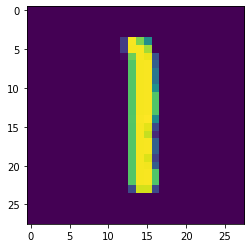

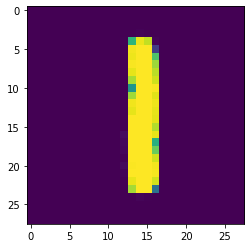

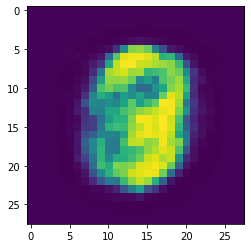

 15%|█▌        | 36/235 [00:14<01:16,  2.61it/s]

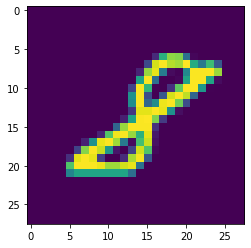

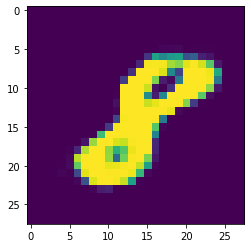

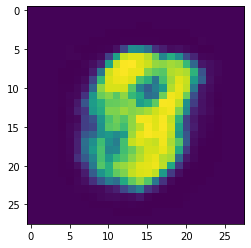

 16%|█▌        | 37/235 [00:14<01:15,  2.63it/s]

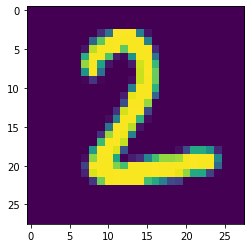

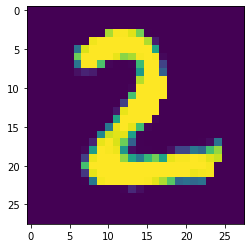

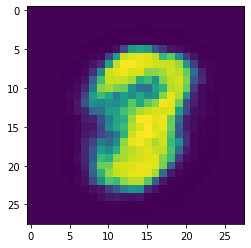

 16%|█▌        | 38/235 [00:15<01:17,  2.56it/s]

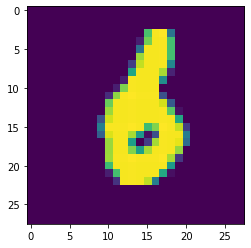

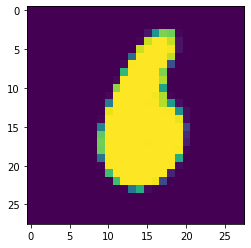

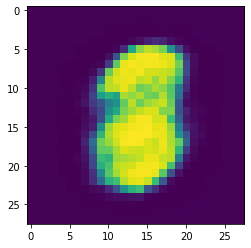

 17%|█▋        | 39/235 [00:15<01:15,  2.59it/s]

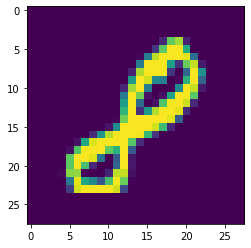

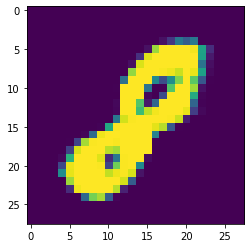

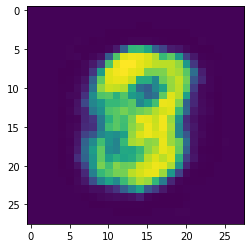

 17%|█▋        | 40/235 [00:16<01:14,  2.61it/s]

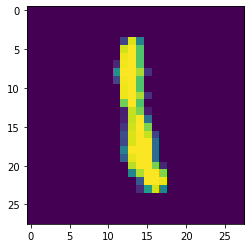

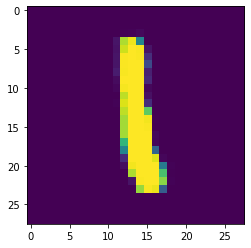

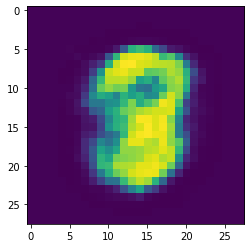

 17%|█▋        | 41/235 [00:16<01:13,  2.62it/s]

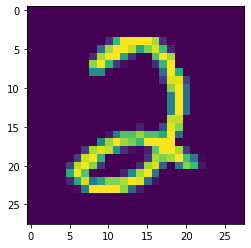

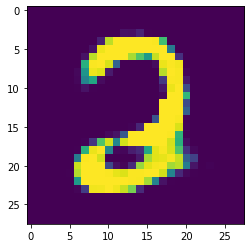

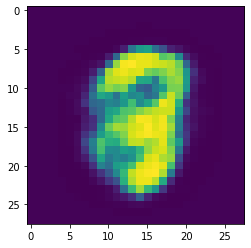

 18%|█▊        | 42/235 [00:16<01:15,  2.56it/s]

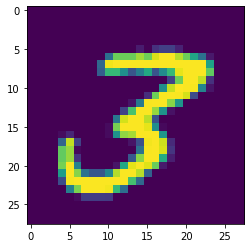

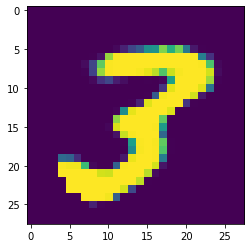

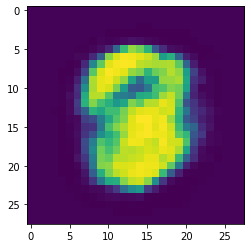

 18%|█▊        | 43/235 [00:17<01:14,  2.59it/s]

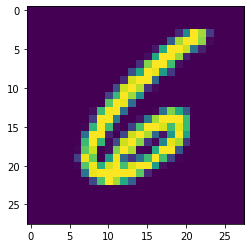

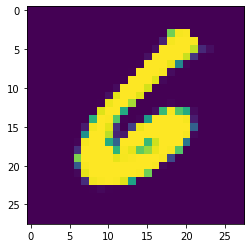

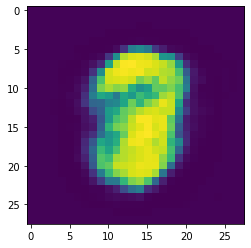

 19%|█▊        | 44/235 [00:17<01:13,  2.61it/s]

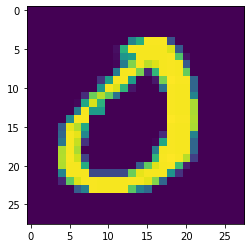

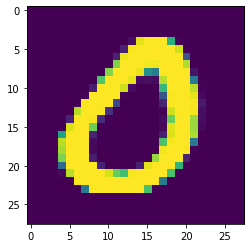

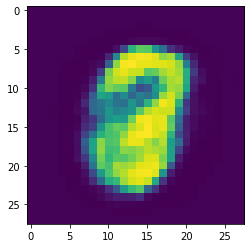

 19%|█▉        | 45/235 [00:18<01:12,  2.63it/s]

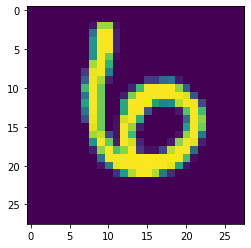

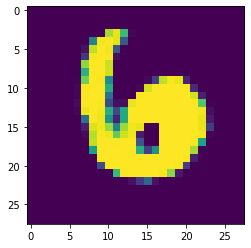

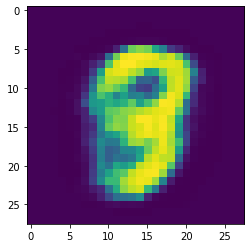

 20%|█▉        | 46/235 [00:18<01:14,  2.55it/s]

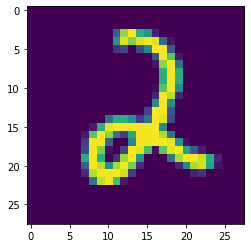

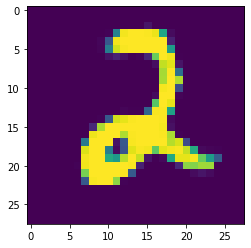

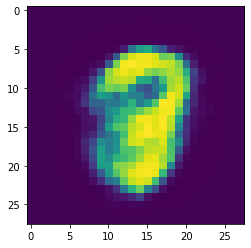

 20%|██        | 47/235 [00:18<01:12,  2.59it/s]

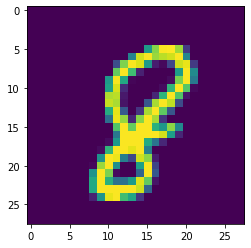

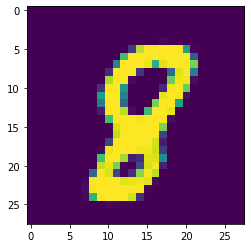

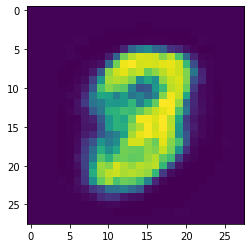

 20%|██        | 48/235 [00:19<01:11,  2.61it/s]

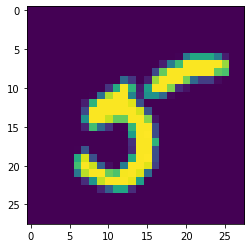

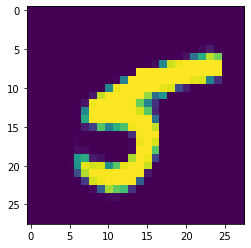

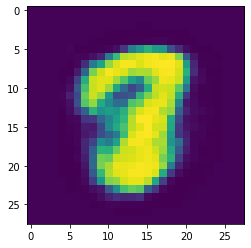

 21%|██        | 49/235 [00:19<01:10,  2.62it/s]

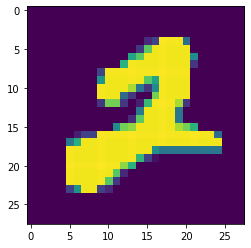

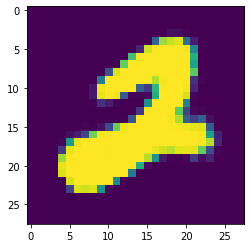

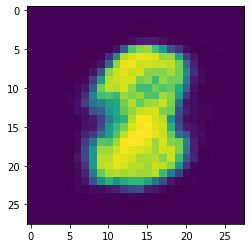

 21%|██▏       | 50/235 [00:20<01:12,  2.56it/s]

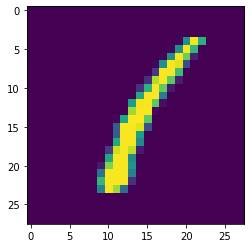

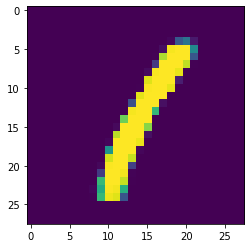

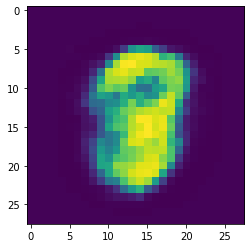

 22%|██▏       | 51/235 [00:20<01:11,  2.59it/s]

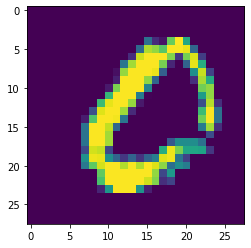

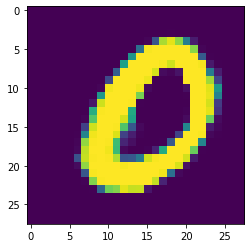

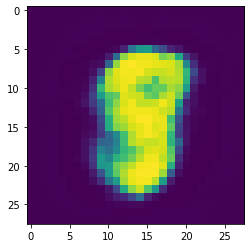

 22%|██▏       | 52/235 [00:20<01:10,  2.61it/s]

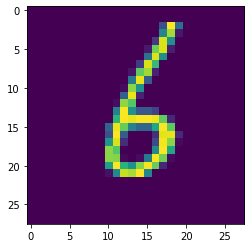

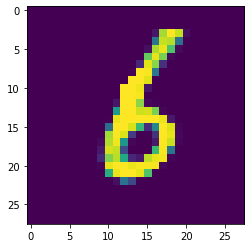

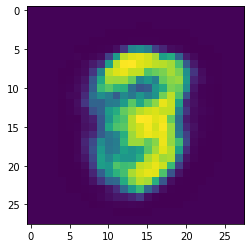

 23%|██▎       | 53/235 [00:21<01:09,  2.63it/s]

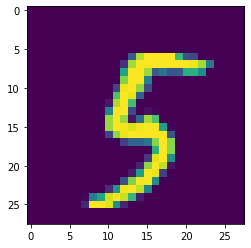

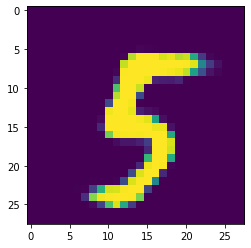

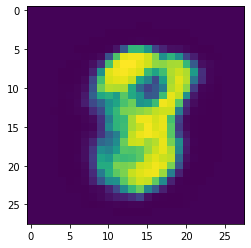

 23%|██▎       | 54/235 [00:21<01:10,  2.55it/s]

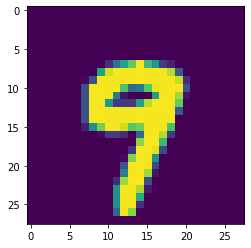

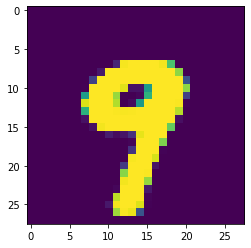

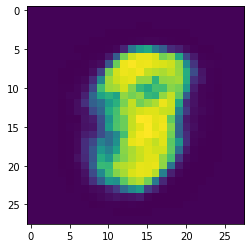

 23%|██▎       | 55/235 [00:21<01:09,  2.58it/s]

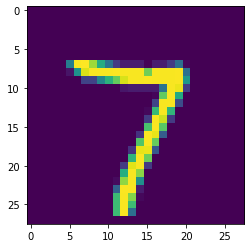

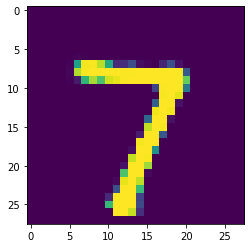

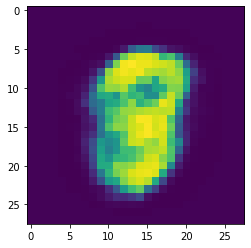

 24%|██▍       | 56/235 [00:22<01:08,  2.60it/s]

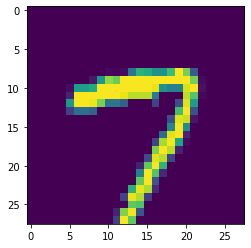

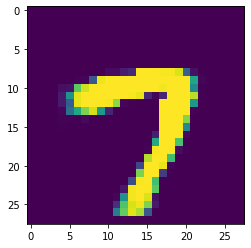

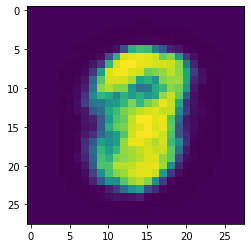

 24%|██▍       | 57/235 [00:22<01:07,  2.62it/s]

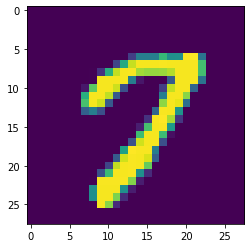

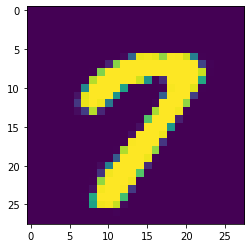

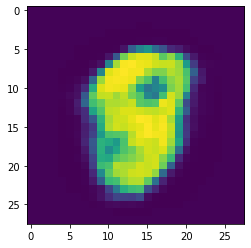

 25%|██▍       | 58/235 [00:23<01:09,  2.55it/s]

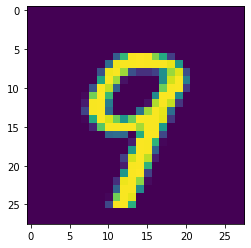

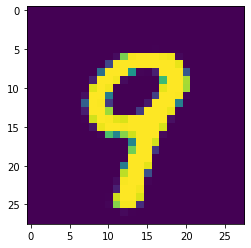

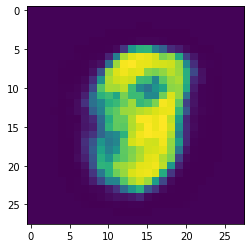

 25%|██▌       | 59/235 [00:23<01:08,  2.58it/s]

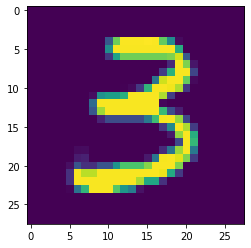

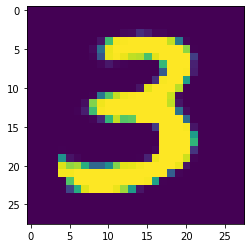

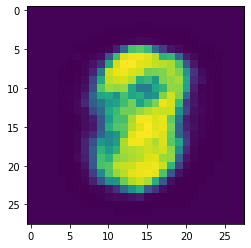

 26%|██▌       | 60/235 [00:23<01:07,  2.60it/s]

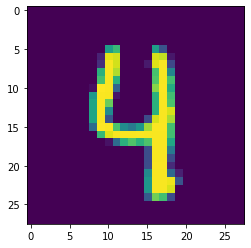

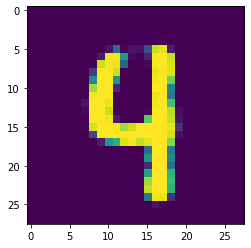

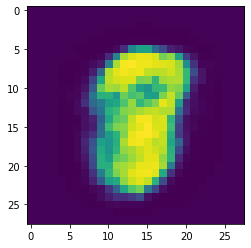

 26%|██▌       | 61/235 [00:24<01:06,  2.62it/s]

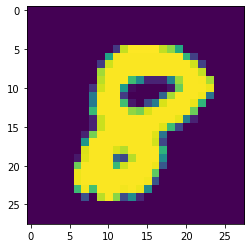

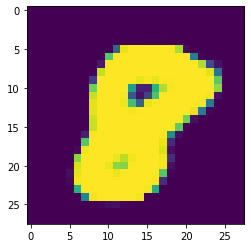

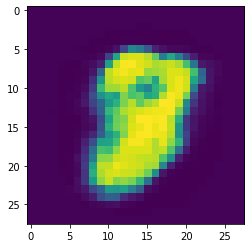

 26%|██▋       | 62/235 [00:24<01:07,  2.55it/s]

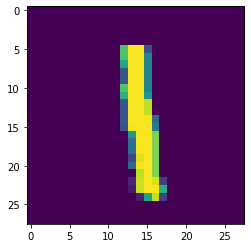

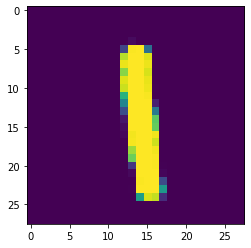

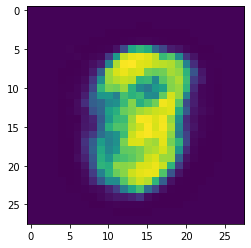

 27%|██▋       | 63/235 [00:25<01:06,  2.58it/s]

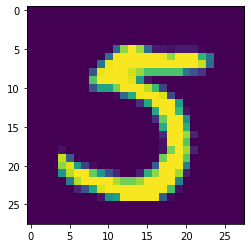

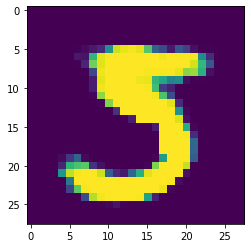

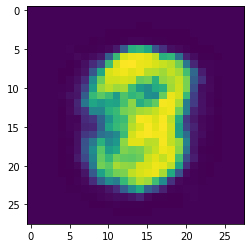

 27%|██▋       | 64/235 [00:25<01:05,  2.61it/s]

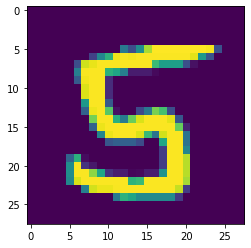

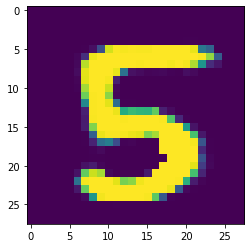

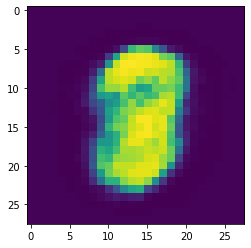

 28%|██▊       | 65/235 [00:25<01:04,  2.62it/s]

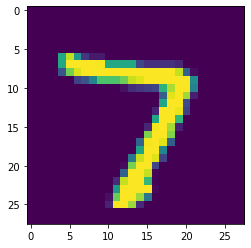

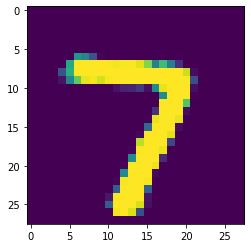

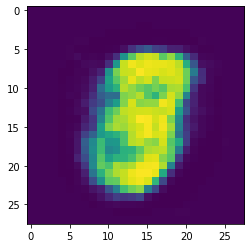

 28%|██▊       | 66/235 [00:26<01:06,  2.55it/s]

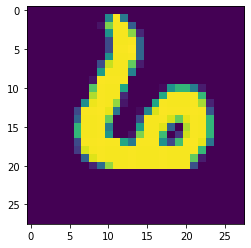

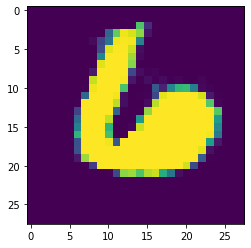

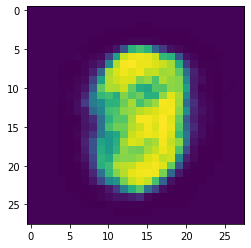

 29%|██▊       | 67/235 [00:26<01:05,  2.58it/s]

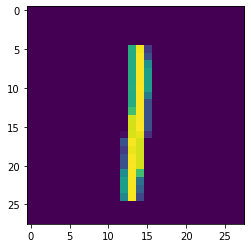

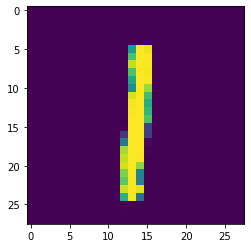

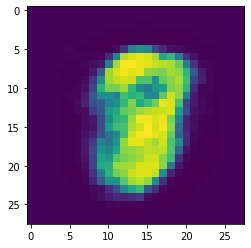

 29%|██▉       | 68/235 [00:26<01:04,  2.61it/s]

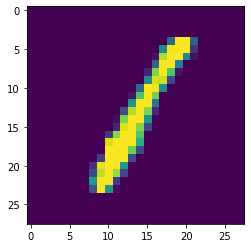

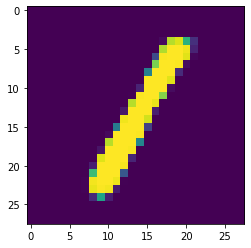

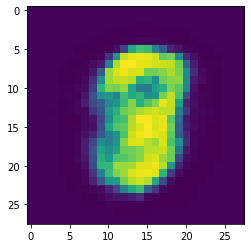

 29%|██▉       | 69/235 [00:27<01:03,  2.62it/s]

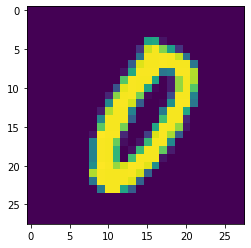

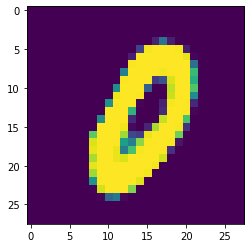

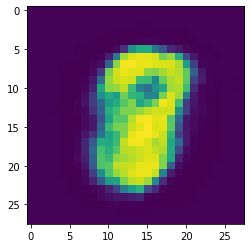

 30%|██▉       | 70/235 [00:27<01:04,  2.55it/s]

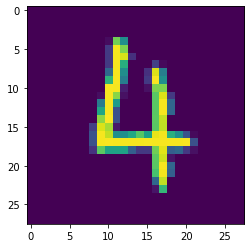

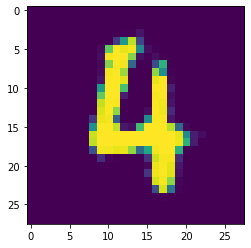

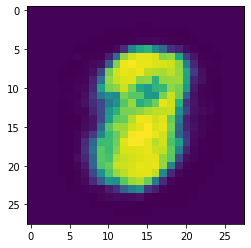

 30%|███       | 71/235 [00:28<01:03,  2.58it/s]

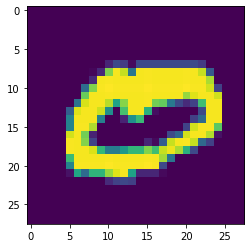

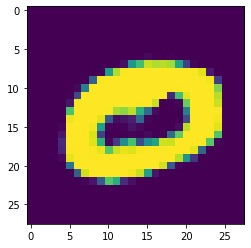

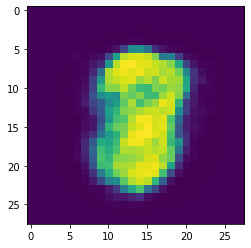

 31%|███       | 72/235 [00:28<01:02,  2.60it/s]

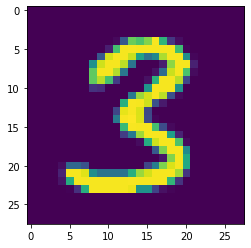

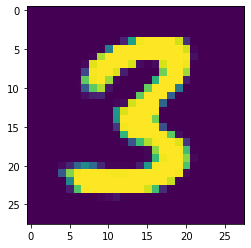

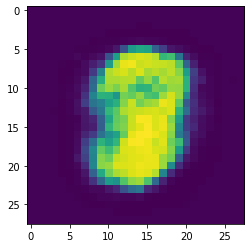

 31%|███       | 73/235 [00:28<01:01,  2.62it/s]

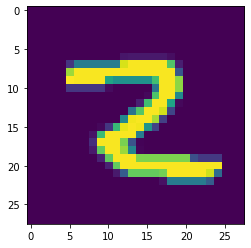

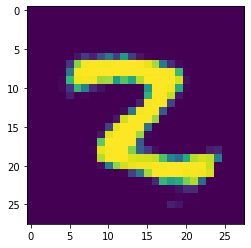

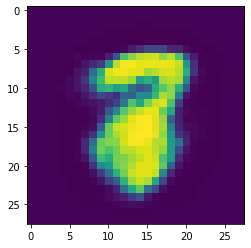

 31%|███▏      | 74/235 [00:29<01:03,  2.55it/s]

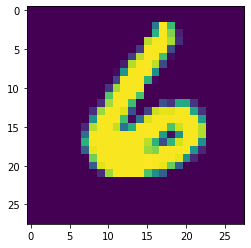

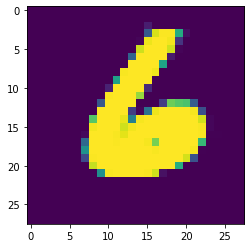

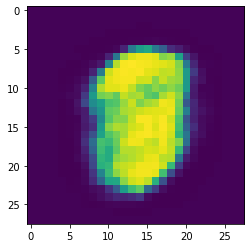

 32%|███▏      | 75/235 [00:29<01:01,  2.58it/s]

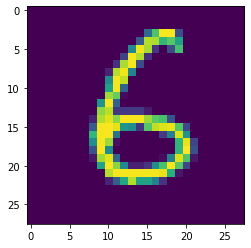

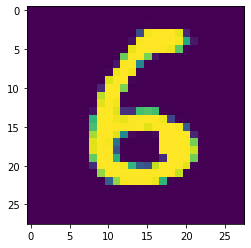

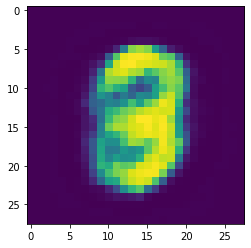

 32%|███▏      | 76/235 [00:30<01:01,  2.60it/s]

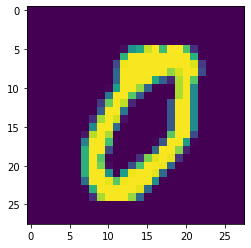

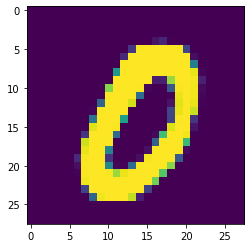

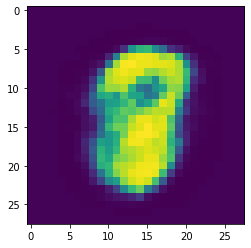

 33%|███▎      | 77/235 [00:30<01:00,  2.62it/s]

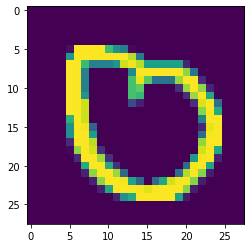

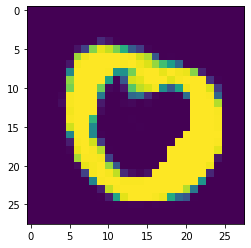

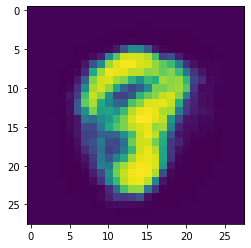

 33%|███▎      | 78/235 [00:30<01:01,  2.55it/s]

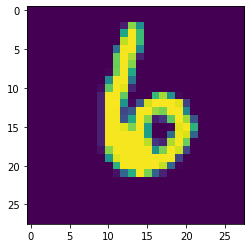

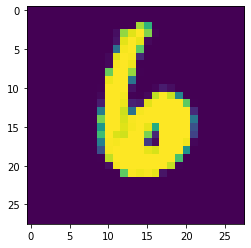

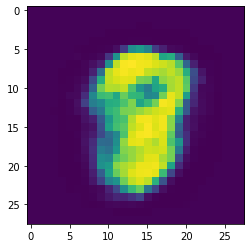

 34%|███▎      | 79/235 [00:31<01:00,  2.58it/s]

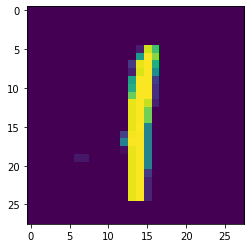

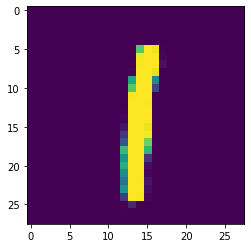

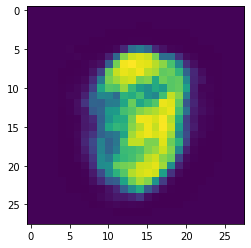

 34%|███▍      | 80/235 [00:31<00:59,  2.61it/s]

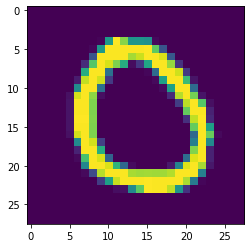

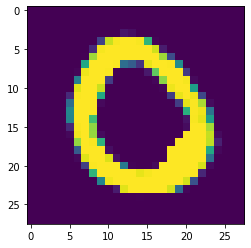

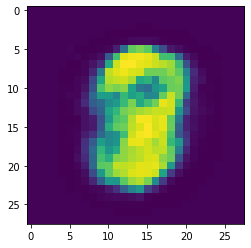

 34%|███▍      | 81/235 [00:31<00:58,  2.62it/s]

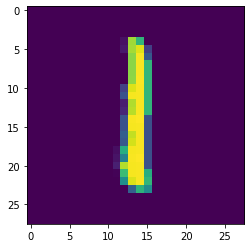

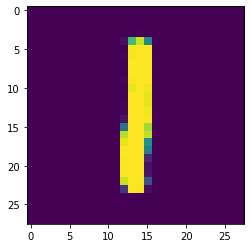

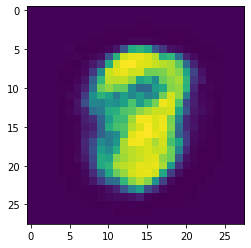

 35%|███▍      | 82/235 [00:32<00:59,  2.55it/s]

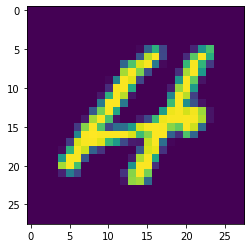

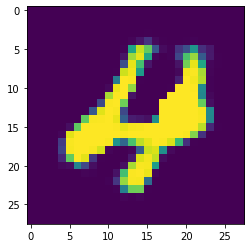

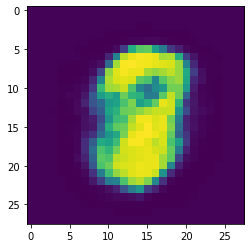

 35%|███▌      | 83/235 [00:32<00:58,  2.59it/s]

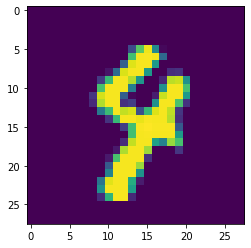

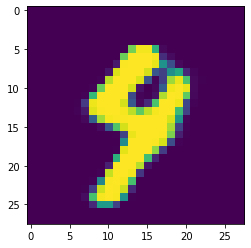

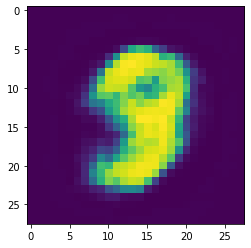

 36%|███▌      | 84/235 [00:33<00:58,  2.60it/s]

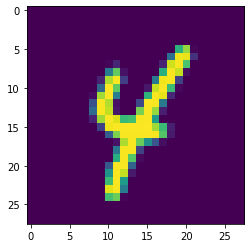

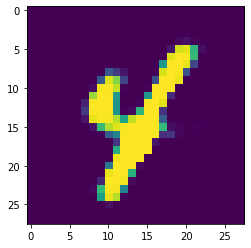

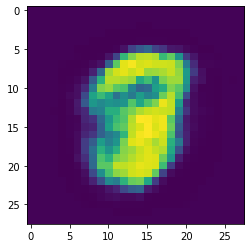

 36%|███▌      | 85/235 [00:33<00:57,  2.62it/s]

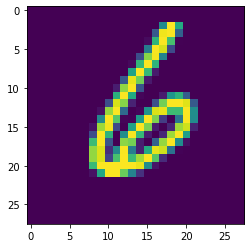

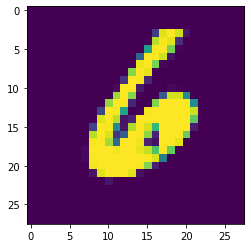

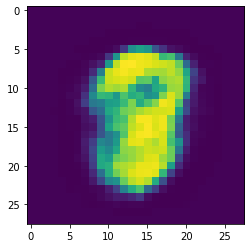

 37%|███▋      | 86/235 [00:33<00:58,  2.55it/s]

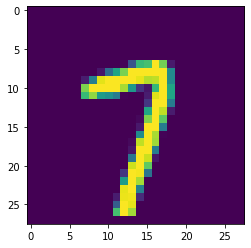

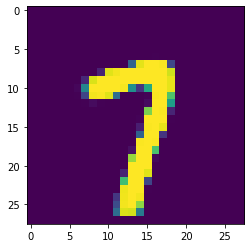

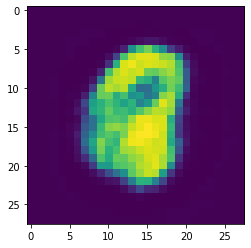

 37%|███▋      | 87/235 [00:34<00:57,  2.58it/s]

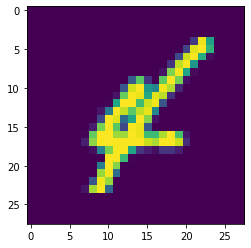

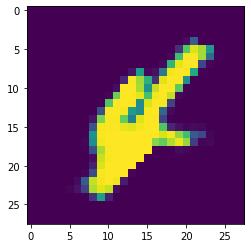

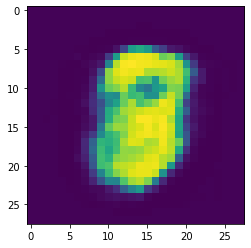

 37%|███▋      | 88/235 [00:34<00:56,  2.61it/s]

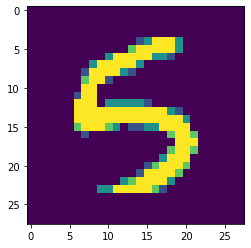

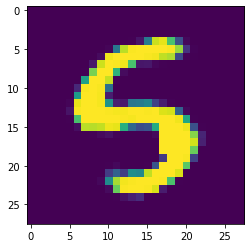

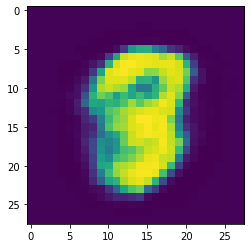

 38%|███▊      | 89/235 [00:35<00:55,  2.62it/s]

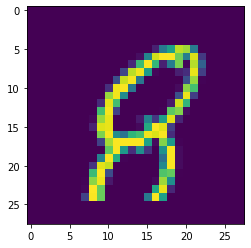

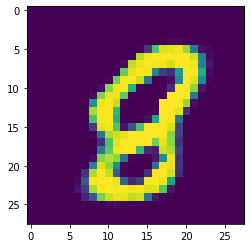

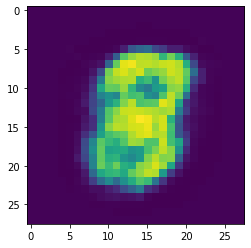

 38%|███▊      | 90/235 [00:35<00:56,  2.55it/s]

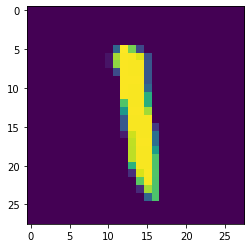

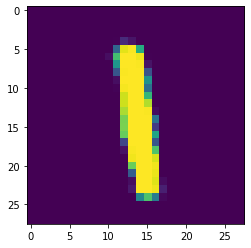

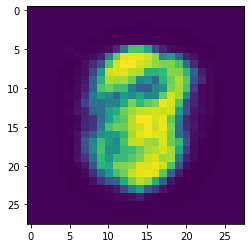

 39%|███▊      | 91/235 [00:35<00:55,  2.58it/s]

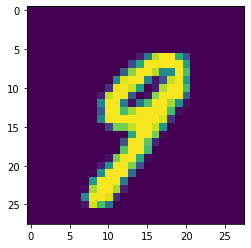

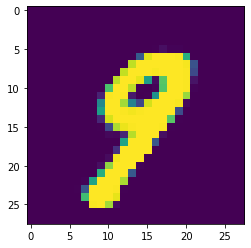

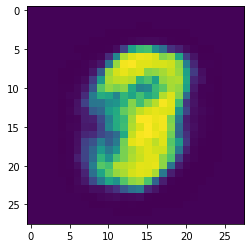

 39%|███▉      | 92/235 [00:36<00:54,  2.60it/s]

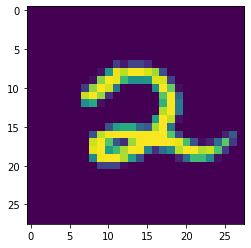

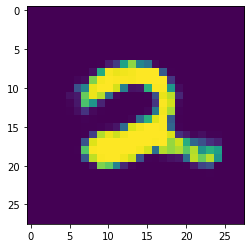

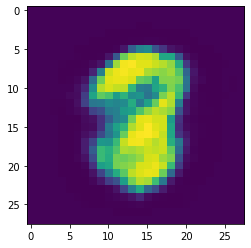

 40%|███▉      | 93/235 [00:36<00:54,  2.62it/s]

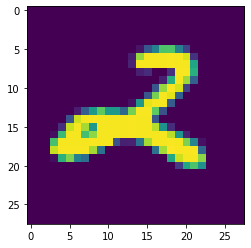

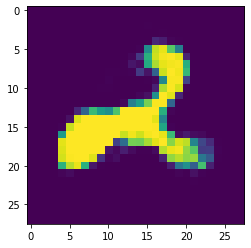

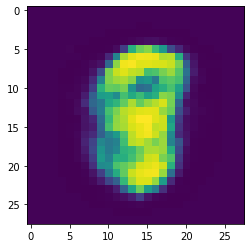

 40%|████      | 94/235 [00:37<00:55,  2.55it/s]

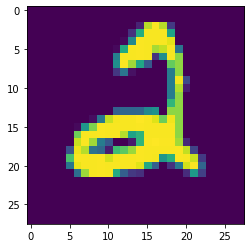

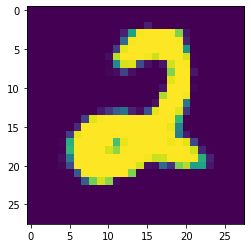

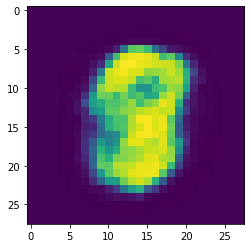

 40%|████      | 95/235 [00:37<00:54,  2.58it/s]

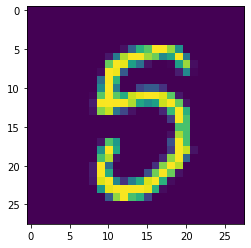

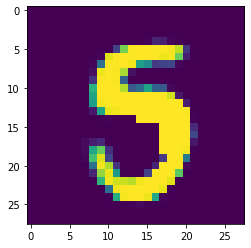

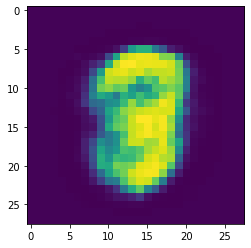

 41%|████      | 96/235 [00:37<00:53,  2.61it/s]

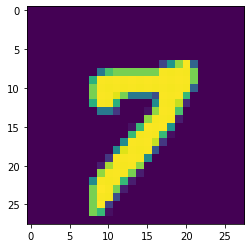

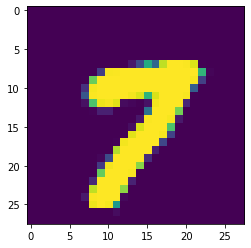

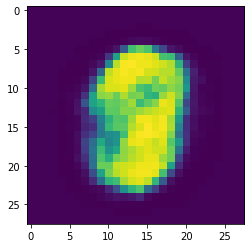

 41%|████▏     | 97/235 [00:38<00:52,  2.62it/s]

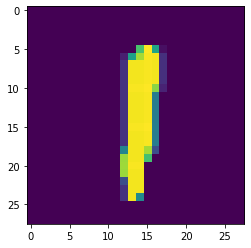

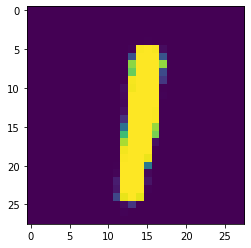

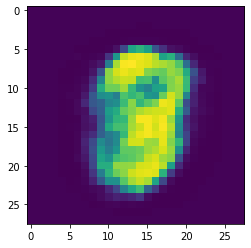

 42%|████▏     | 98/235 [00:38<00:53,  2.55it/s]

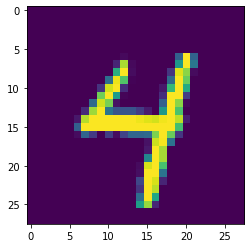

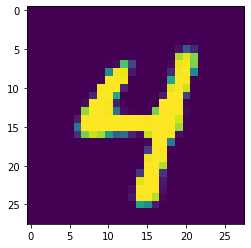

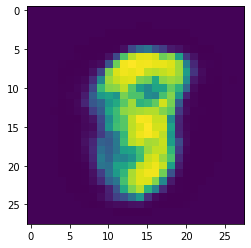

 42%|████▏     | 99/235 [00:38<00:52,  2.58it/s]

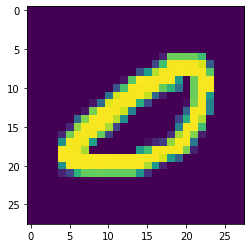

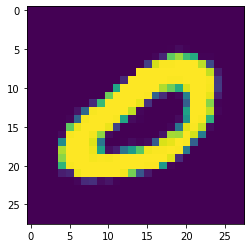

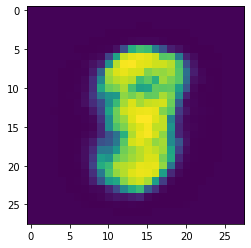

 43%|████▎     | 100/235 [00:39<00:51,  2.60it/s]

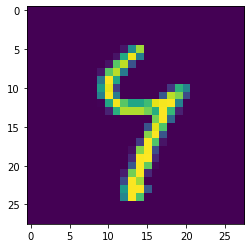

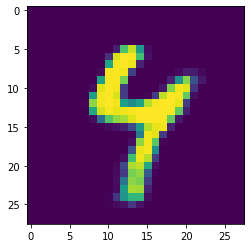

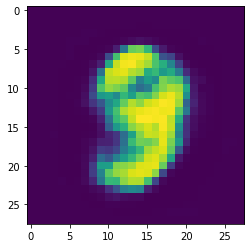

 43%|████▎     | 101/235 [00:39<00:51,  2.62it/s]

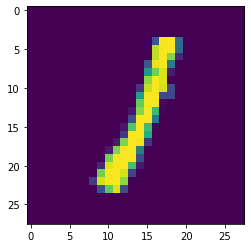

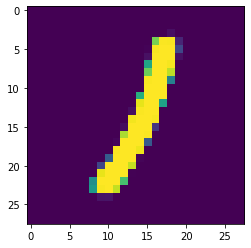

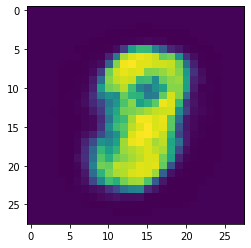

 43%|████▎     | 102/235 [00:40<00:52,  2.55it/s]

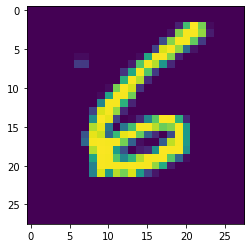

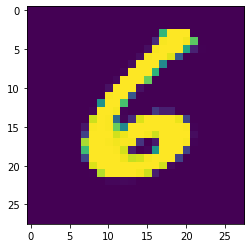

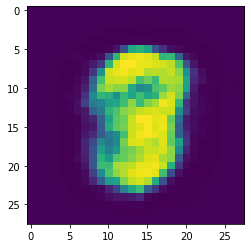

 44%|████▍     | 103/235 [00:40<00:51,  2.58it/s]

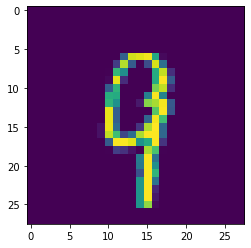

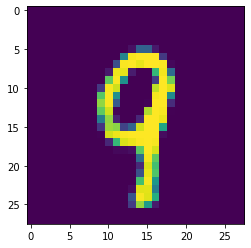

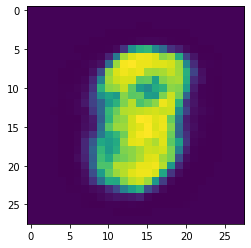

 44%|████▍     | 104/235 [00:40<00:50,  2.61it/s]

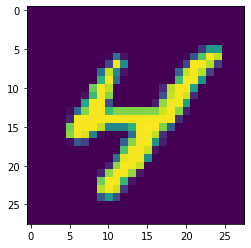

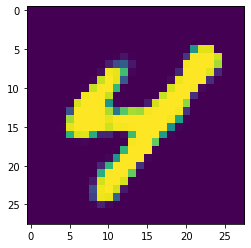

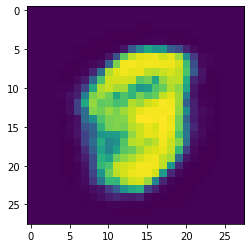

 45%|████▍     | 105/235 [00:41<00:49,  2.62it/s]

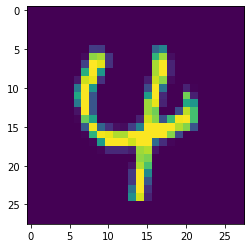

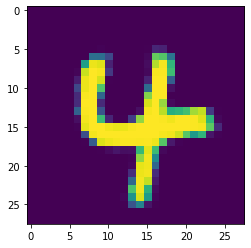

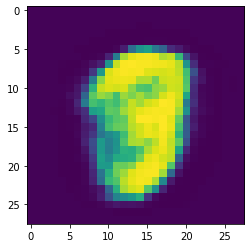

 45%|████▌     | 106/235 [00:41<00:50,  2.55it/s]

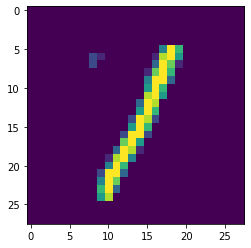

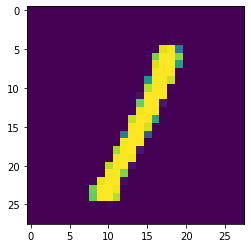

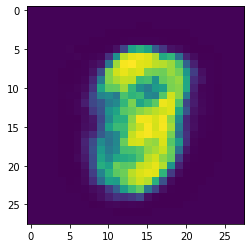

 46%|████▌     | 107/235 [00:42<00:49,  2.58it/s]

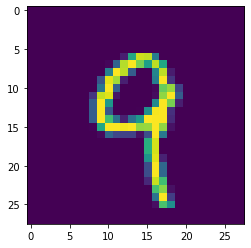

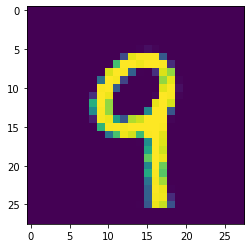

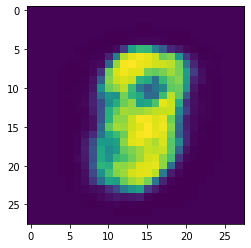

 46%|████▌     | 108/235 [00:42<00:48,  2.60it/s]

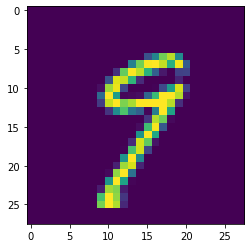

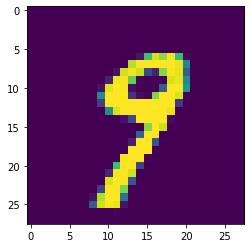

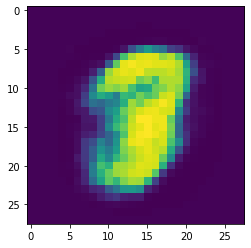

 46%|████▋     | 109/235 [00:42<00:48,  2.62it/s]

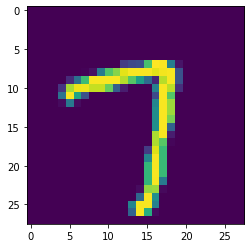

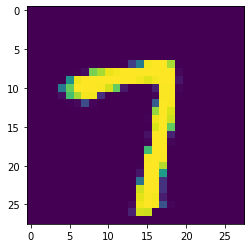

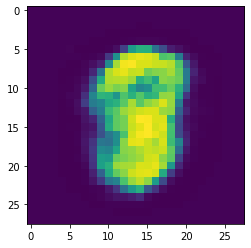

 47%|████▋     | 110/235 [00:43<00:48,  2.55it/s]

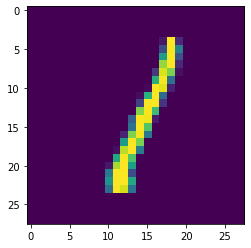

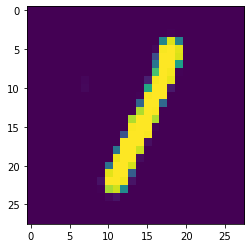

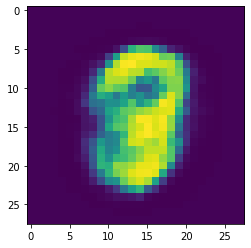

 47%|████▋     | 111/235 [00:43<00:48,  2.58it/s]

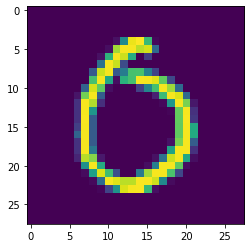

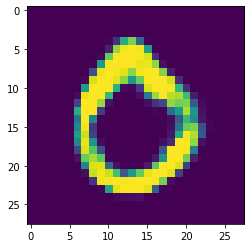

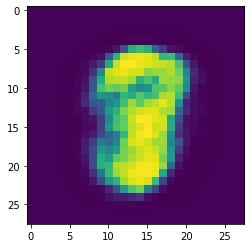

 48%|████▊     | 112/235 [00:43<00:47,  2.60it/s]

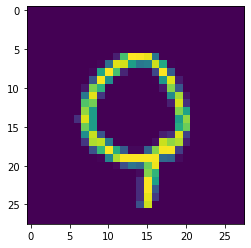

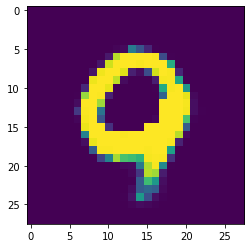

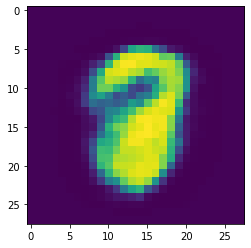

 48%|████▊     | 113/235 [00:44<00:46,  2.62it/s]

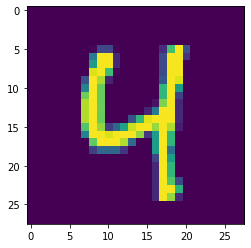

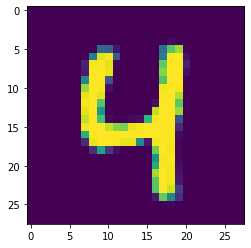

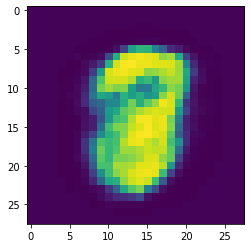

 49%|████▊     | 114/235 [00:44<00:47,  2.55it/s]

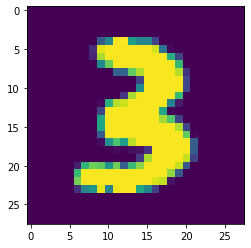

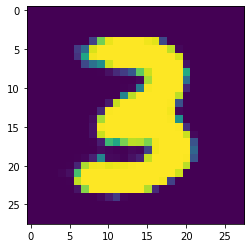

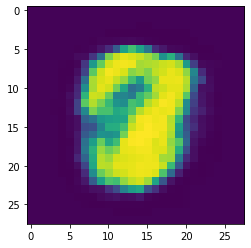

 49%|████▉     | 115/235 [00:45<00:46,  2.58it/s]

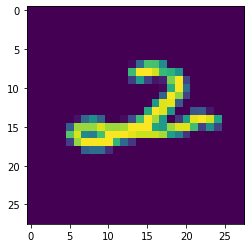

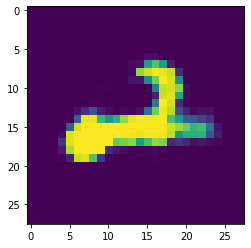

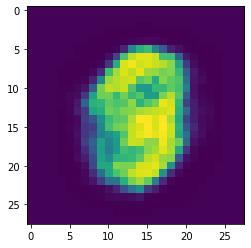

 49%|████▉     | 116/235 [00:45<00:45,  2.60it/s]

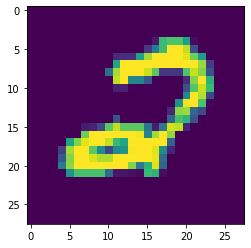

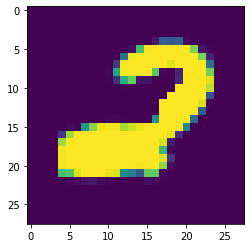

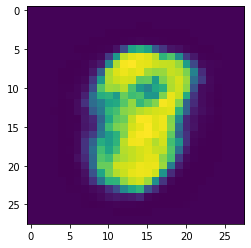

 50%|████▉     | 117/235 [00:45<00:45,  2.62it/s]

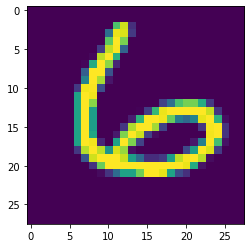

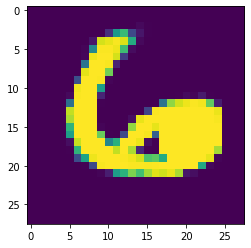

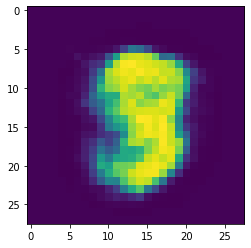

 50%|█████     | 118/235 [00:46<00:45,  2.55it/s]

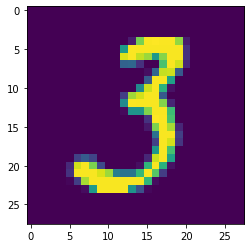

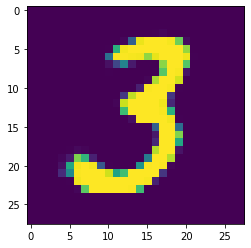

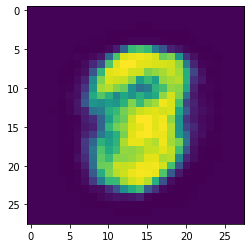

 51%|█████     | 119/235 [00:46<00:44,  2.58it/s]

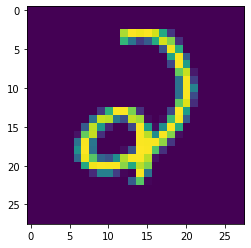

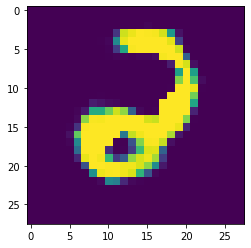

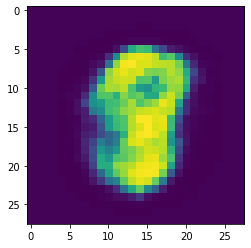

 51%|█████     | 120/235 [00:47<00:44,  2.60it/s]

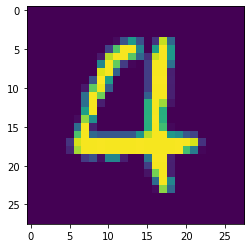

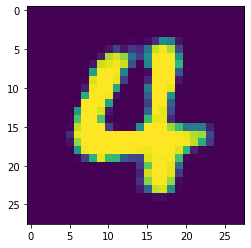

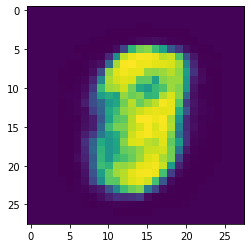

 51%|█████▏    | 121/235 [00:47<00:43,  2.62it/s]

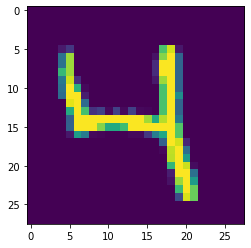

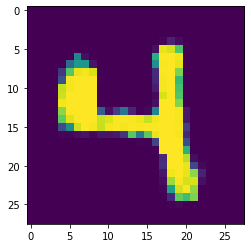

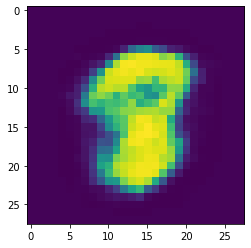

 52%|█████▏    | 122/235 [00:47<00:44,  2.55it/s]

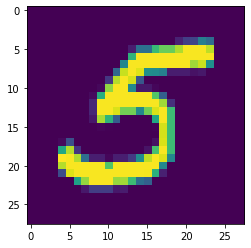

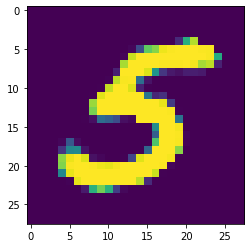

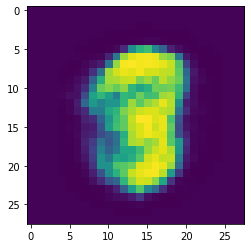

 52%|█████▏    | 123/235 [00:48<00:43,  2.58it/s]

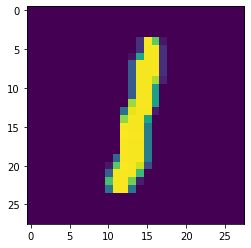

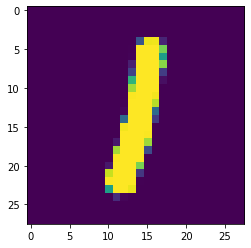

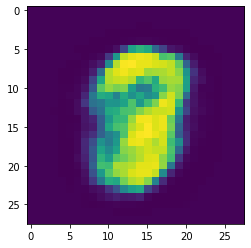

 53%|█████▎    | 124/235 [00:48<00:42,  2.60it/s]

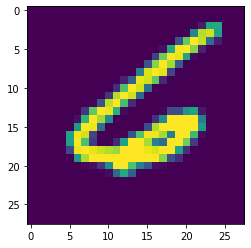

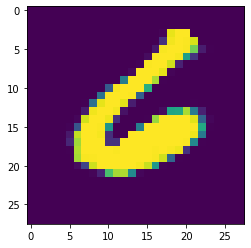

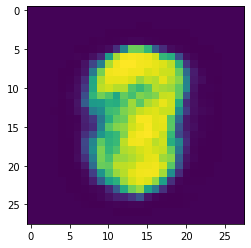

 53%|█████▎    | 125/235 [00:48<00:42,  2.62it/s]

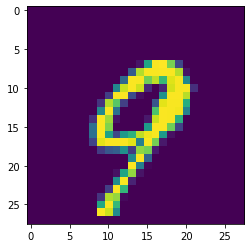

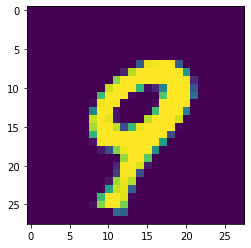

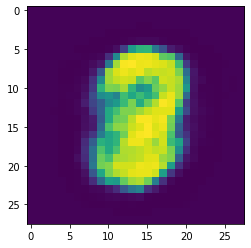

 54%|█████▎    | 126/235 [00:49<00:42,  2.55it/s]

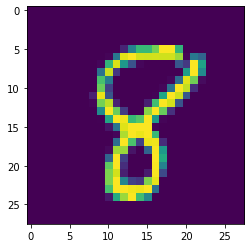

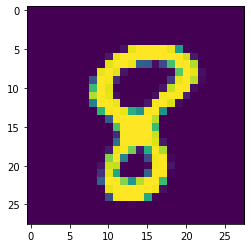

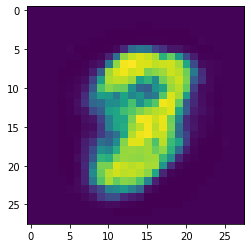

 54%|█████▍    | 127/235 [00:49<00:41,  2.58it/s]

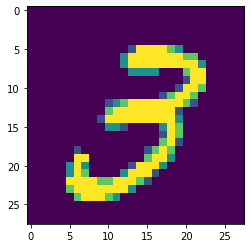

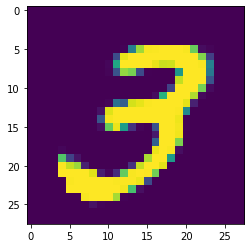

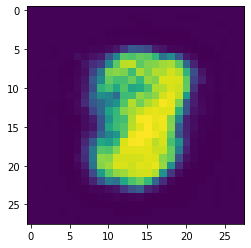

 54%|█████▍    | 128/235 [00:50<00:41,  2.60it/s]

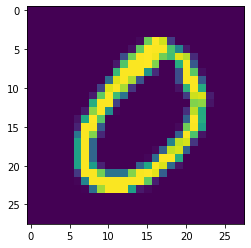

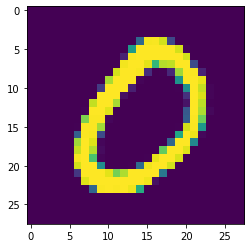

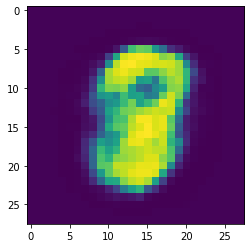

 55%|█████▍    | 129/235 [00:50<00:40,  2.61it/s]

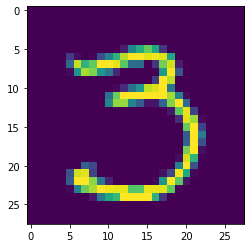

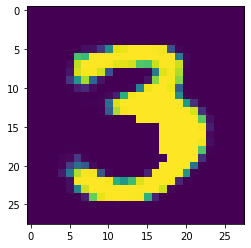

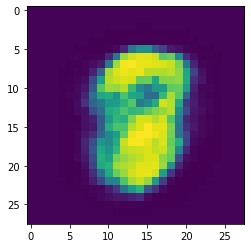

 55%|█████▌    | 130/235 [00:50<00:41,  2.55it/s]

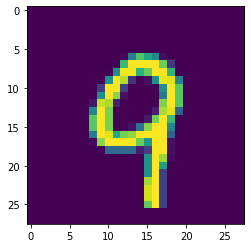

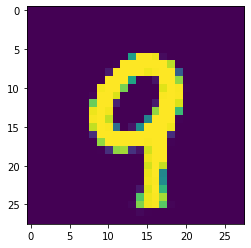

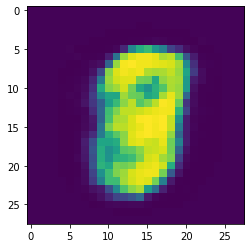

 56%|█████▌    | 131/235 [00:51<00:40,  2.58it/s]

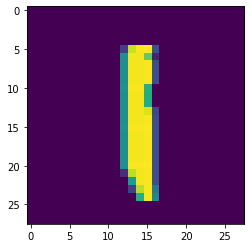

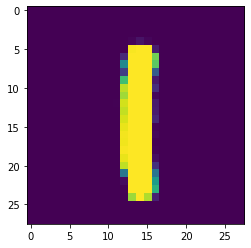

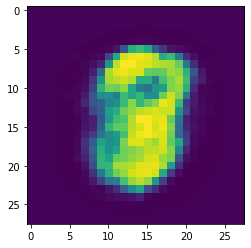

 56%|█████▌    | 132/235 [00:51<00:39,  2.60it/s]

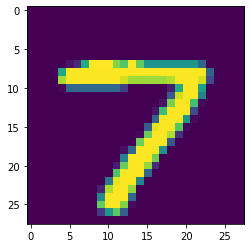

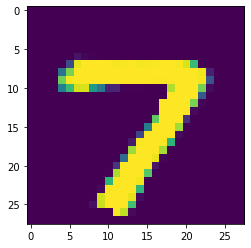

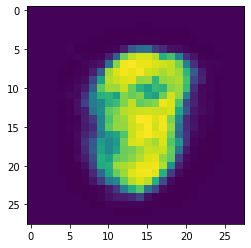

 57%|█████▋    | 133/235 [00:52<00:38,  2.62it/s]

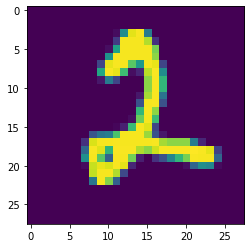

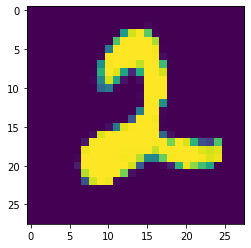

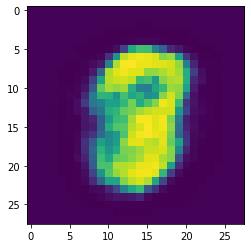

 57%|█████▋    | 134/235 [00:52<00:39,  2.55it/s]

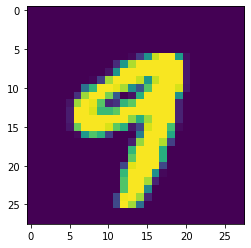

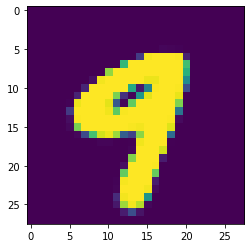

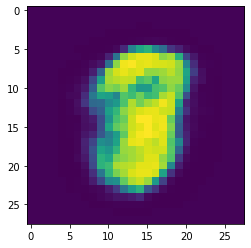

 57%|█████▋    | 135/235 [00:52<00:38,  2.58it/s]

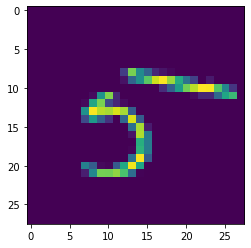

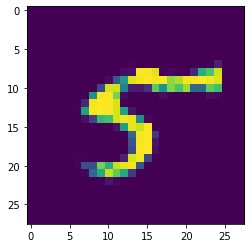

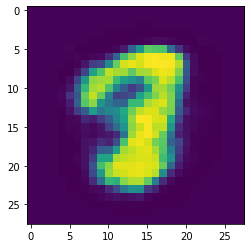

 58%|█████▊    | 136/235 [00:53<00:38,  2.60it/s]

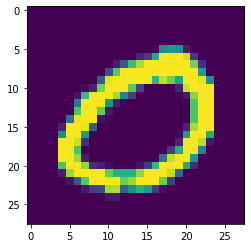

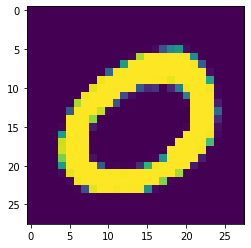

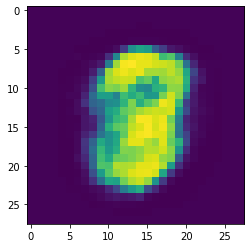

 58%|█████▊    | 137/235 [00:53<00:37,  2.62it/s]

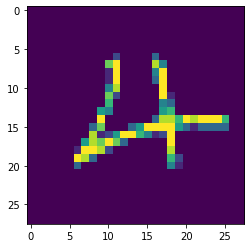

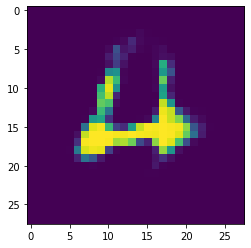

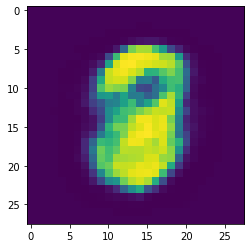

 59%|█████▊    | 138/235 [00:54<00:38,  2.55it/s]

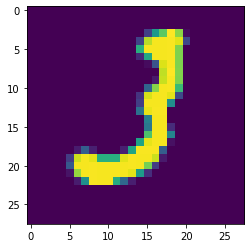

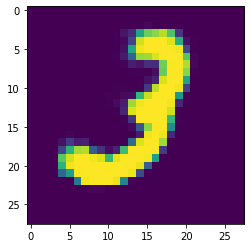

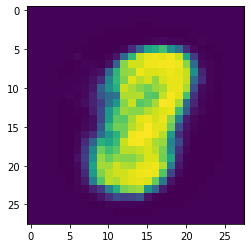

 59%|█████▉    | 139/235 [00:54<00:37,  2.58it/s]

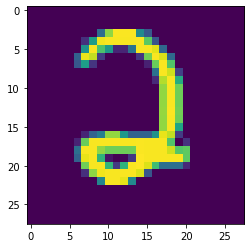

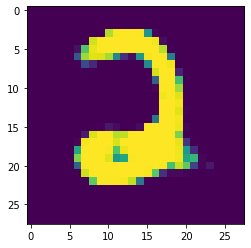

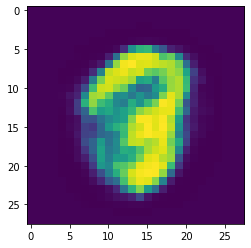

 60%|█████▉    | 140/235 [00:54<00:36,  2.60it/s]

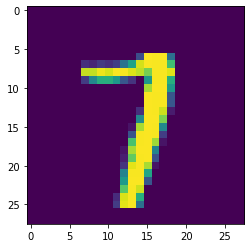

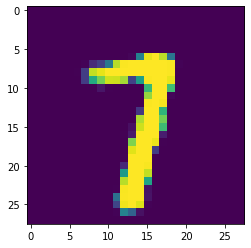

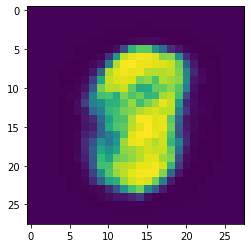

 60%|██████    | 141/235 [00:55<00:36,  2.61it/s]

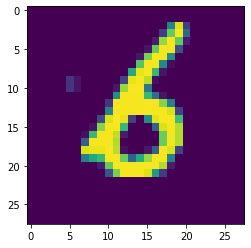

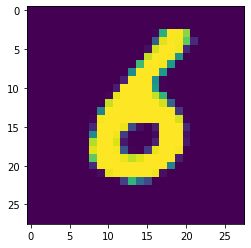

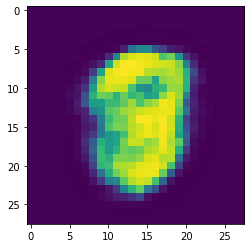

 60%|██████    | 142/235 [00:55<00:36,  2.54it/s]

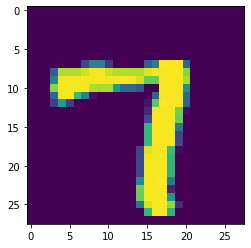

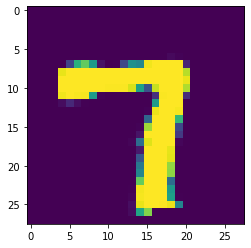

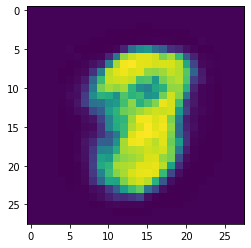

 61%|██████    | 143/235 [00:55<00:35,  2.58it/s]

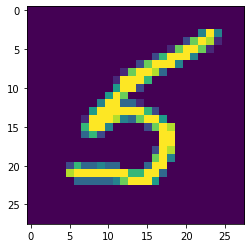

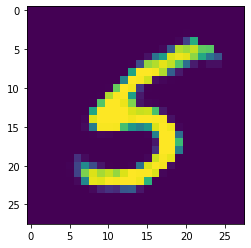

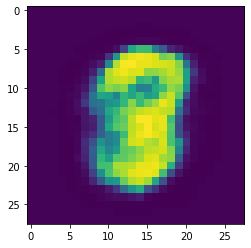

 61%|██████▏   | 144/235 [00:56<00:34,  2.60it/s]

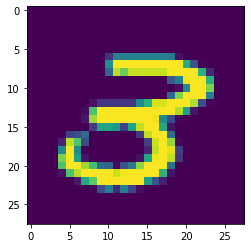

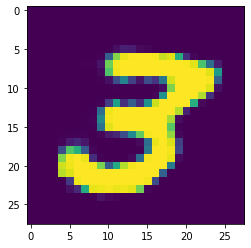

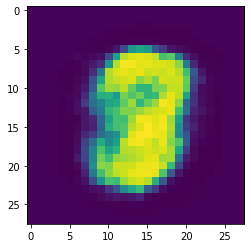

 62%|██████▏   | 145/235 [00:56<00:34,  2.62it/s]

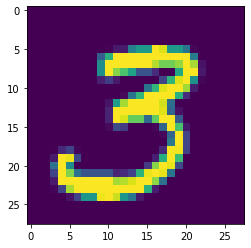

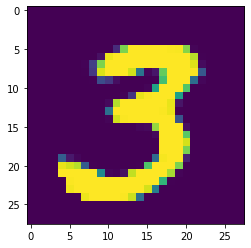

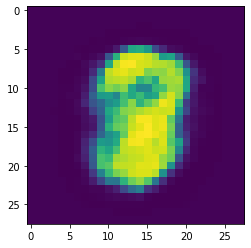

 62%|██████▏   | 146/235 [00:57<00:34,  2.55it/s]

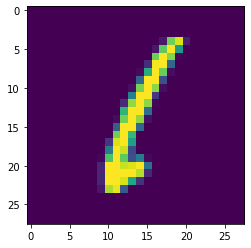

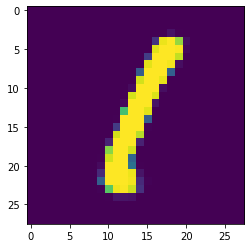

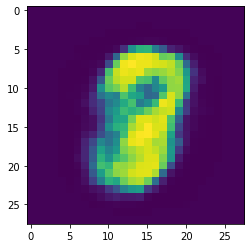

 63%|██████▎   | 147/235 [00:57<00:34,  2.58it/s]

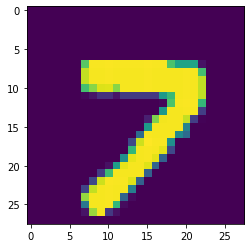

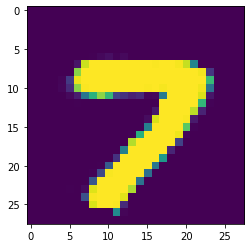

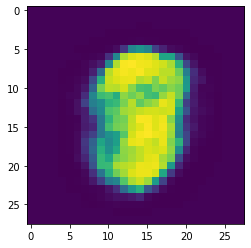

 63%|██████▎   | 148/235 [00:57<00:33,  2.60it/s]

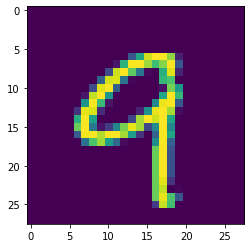

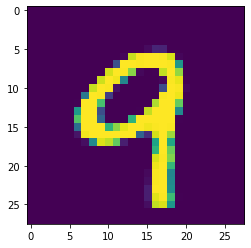

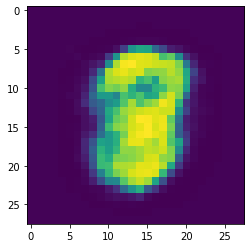

 63%|██████▎   | 149/235 [00:58<00:32,  2.62it/s]

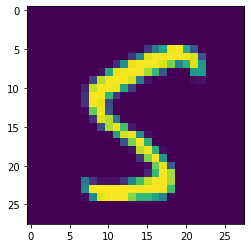

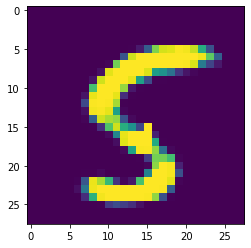

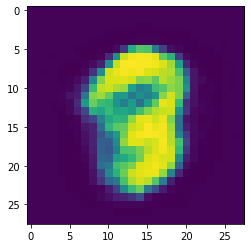

 64%|██████▍   | 150/235 [00:58<00:33,  2.55it/s]

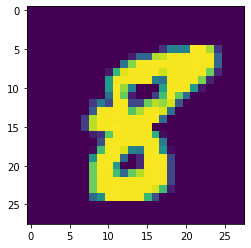

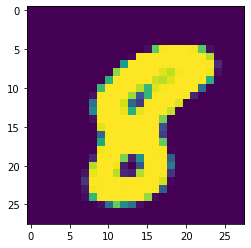

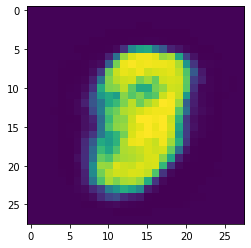

 64%|██████▍   | 151/235 [00:59<00:32,  2.57it/s]

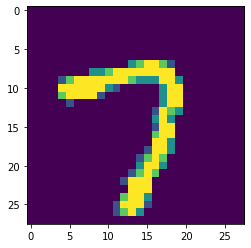

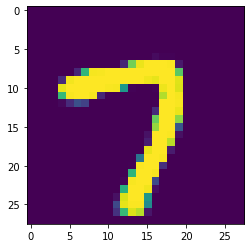

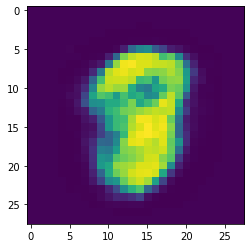

 65%|██████▍   | 152/235 [00:59<00:31,  2.60it/s]

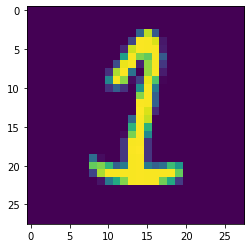

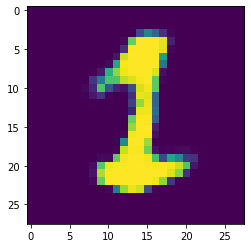

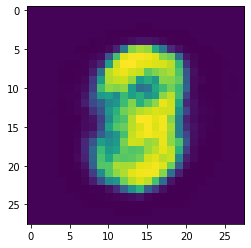

 65%|██████▌   | 153/235 [00:59<00:31,  2.61it/s]

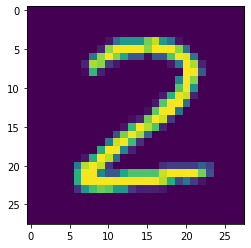

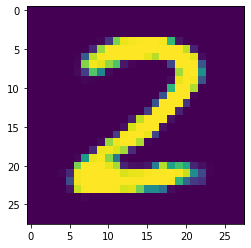

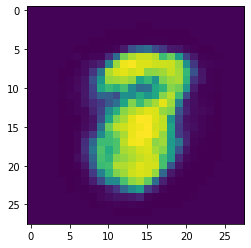

 66%|██████▌   | 154/235 [01:00<00:31,  2.54it/s]

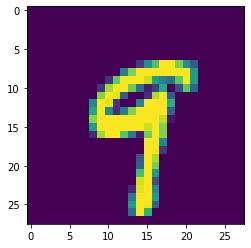

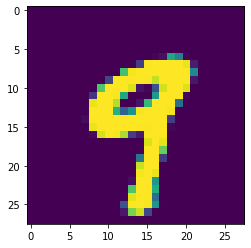

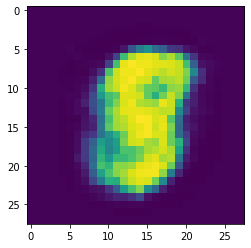

 66%|██████▌   | 155/235 [01:00<00:31,  2.57it/s]

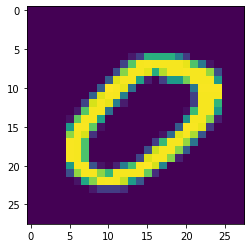

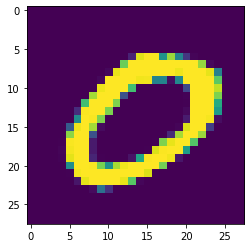

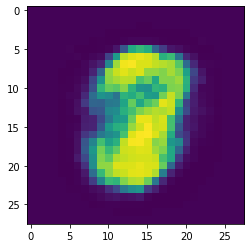

 66%|██████▋   | 156/235 [01:00<00:30,  2.60it/s]

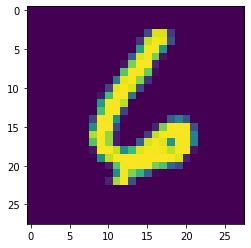

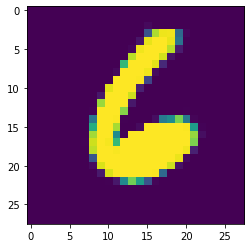

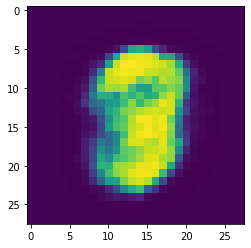

 67%|██████▋   | 157/235 [01:01<00:29,  2.62it/s]

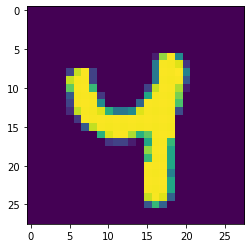

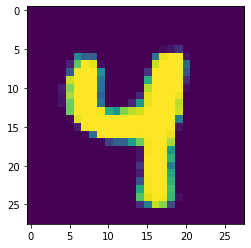

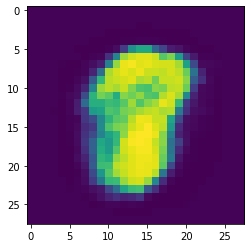

 67%|██████▋   | 158/235 [01:01<00:30,  2.55it/s]

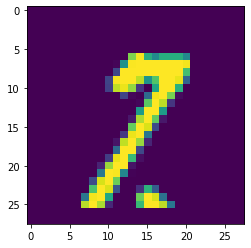

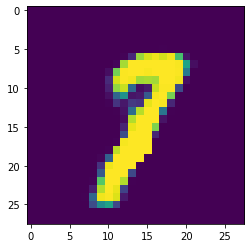

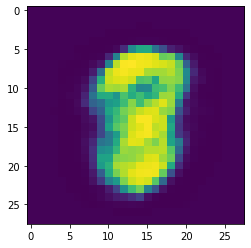

 68%|██████▊   | 159/235 [01:02<00:29,  2.58it/s]

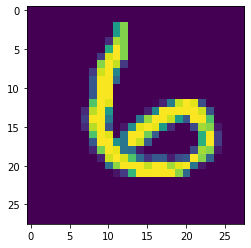

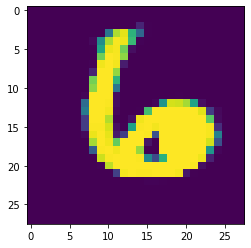

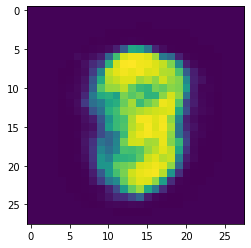

 68%|██████▊   | 160/235 [01:02<00:28,  2.59it/s]

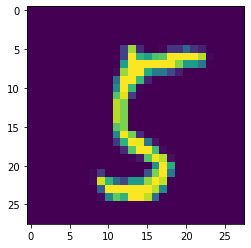

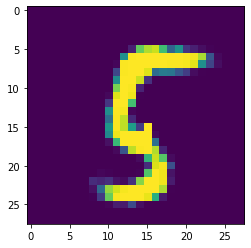

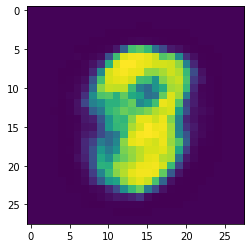

 69%|██████▊   | 161/235 [01:02<00:28,  2.61it/s]

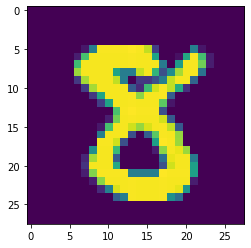

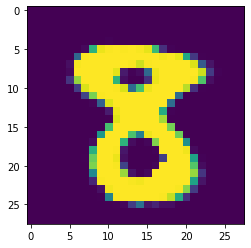

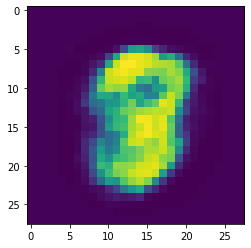

 69%|██████▉   | 162/235 [01:03<00:28,  2.54it/s]

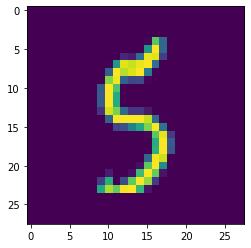

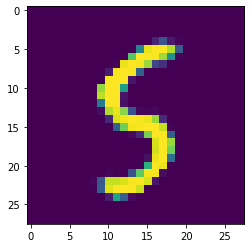

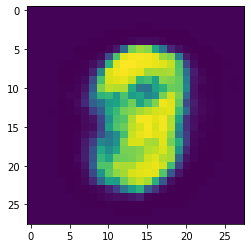

 69%|██████▉   | 163/235 [01:03<00:27,  2.58it/s]

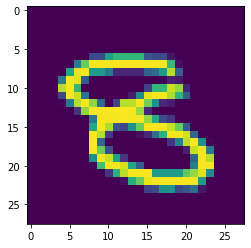

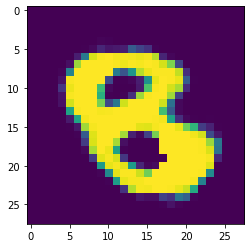

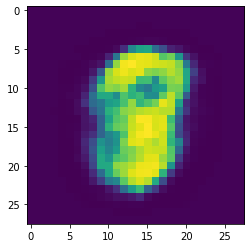

 70%|██████▉   | 164/235 [01:04<00:27,  2.60it/s]

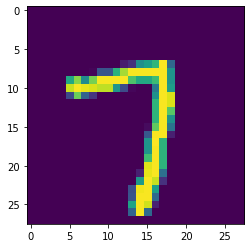

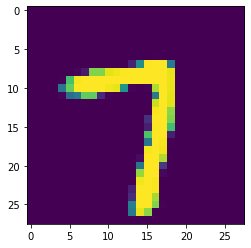

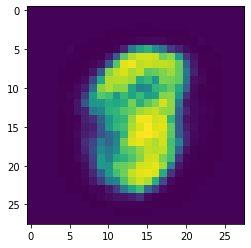

 70%|███████   | 165/235 [01:04<00:26,  2.62it/s]

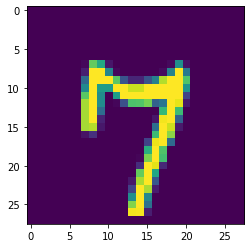

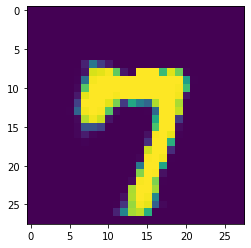

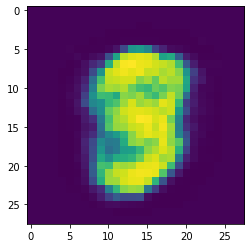

 71%|███████   | 166/235 [01:04<00:27,  2.55it/s]

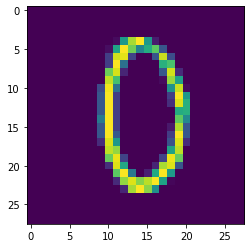

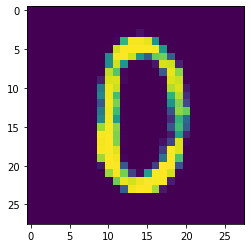

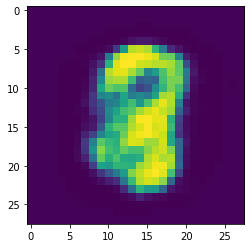

 71%|███████   | 167/235 [01:05<00:26,  2.58it/s]

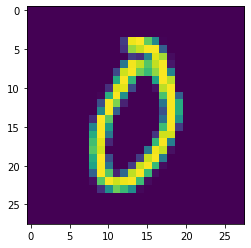

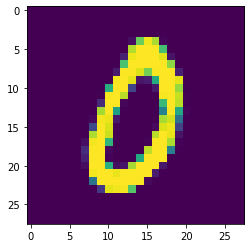

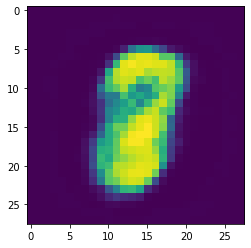

 71%|███████▏  | 168/235 [01:05<00:25,  2.60it/s]

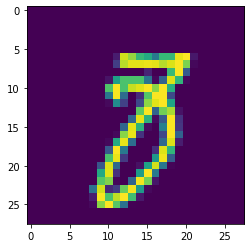

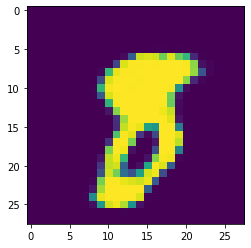

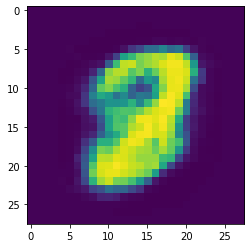

 72%|███████▏  | 169/235 [01:05<00:25,  2.61it/s]

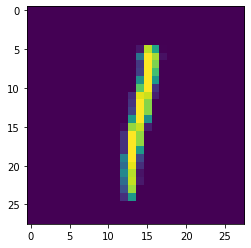

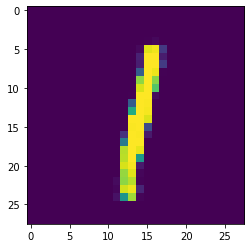

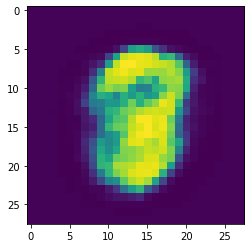

 72%|███████▏  | 170/235 [01:06<00:25,  2.55it/s]

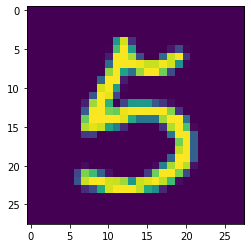

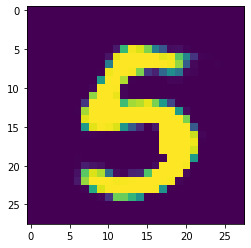

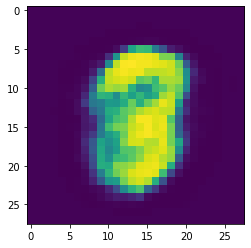

 73%|███████▎  | 171/235 [01:06<00:24,  2.58it/s]

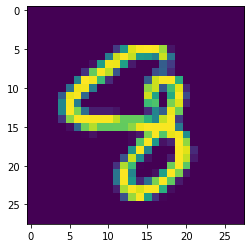

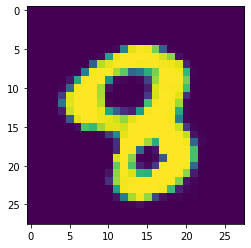

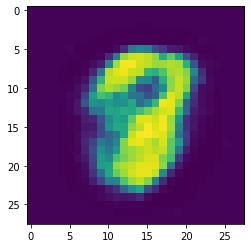

 73%|███████▎  | 172/235 [01:07<00:24,  2.60it/s]

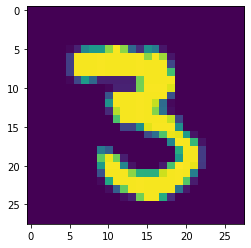

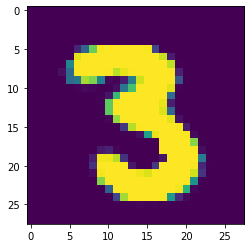

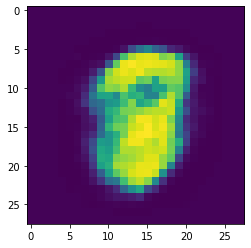

 74%|███████▎  | 173/235 [01:07<00:23,  2.61it/s]

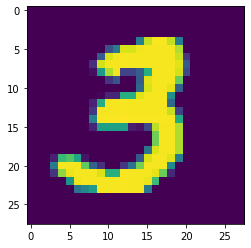

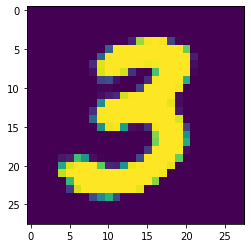

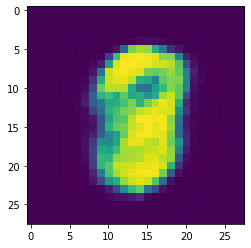

 74%|███████▍  | 174/235 [01:07<00:23,  2.54it/s]

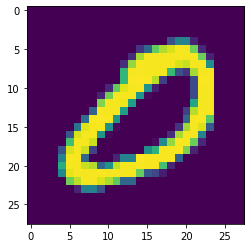

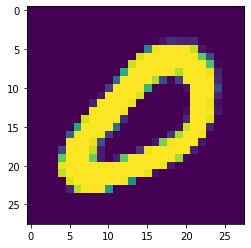

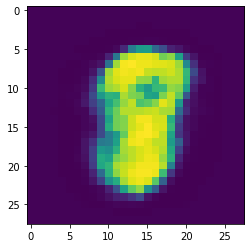

 74%|███████▍  | 175/235 [01:08<00:23,  2.57it/s]

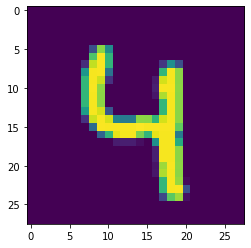

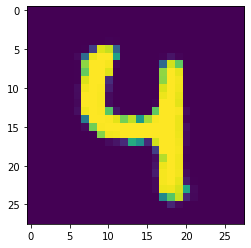

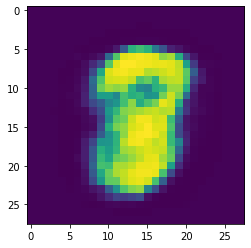

 75%|███████▍  | 176/235 [01:08<00:22,  2.59it/s]

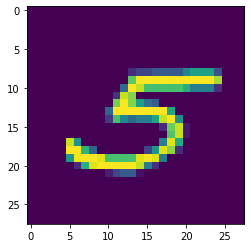

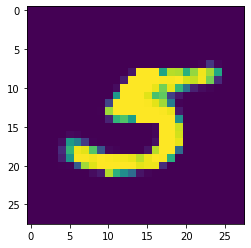

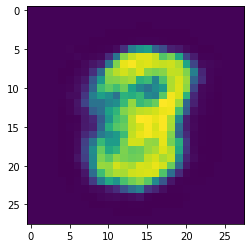

 75%|███████▌  | 177/235 [01:09<00:22,  2.60it/s]

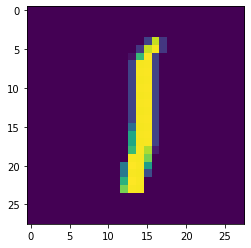

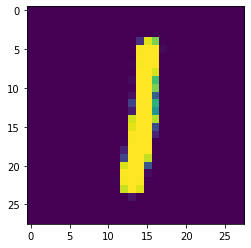

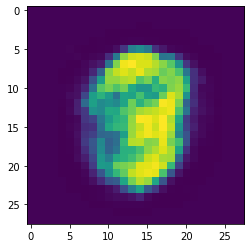

 76%|███████▌  | 178/235 [01:09<00:22,  2.54it/s]

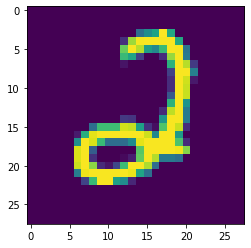

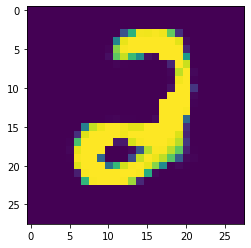

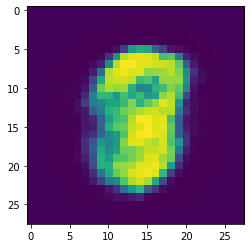

 76%|███████▌  | 179/235 [01:09<00:21,  2.57it/s]

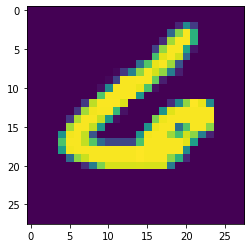

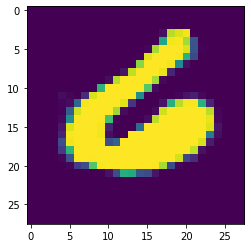

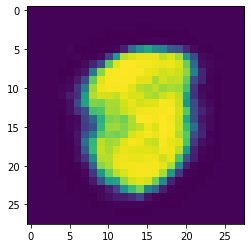

 77%|███████▋  | 180/235 [01:10<00:21,  2.60it/s]

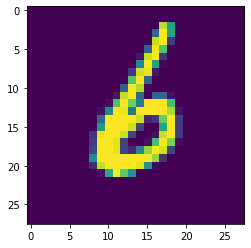

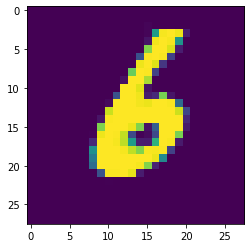

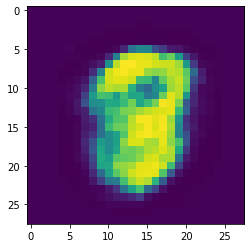

 77%|███████▋  | 181/235 [01:10<00:20,  2.61it/s]

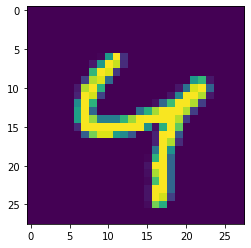

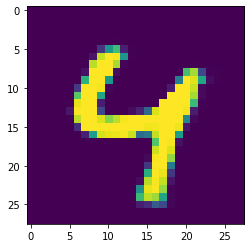

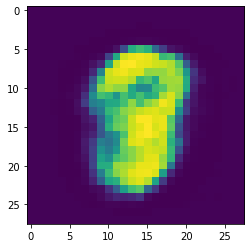

 77%|███████▋  | 182/235 [01:11<00:20,  2.54it/s]

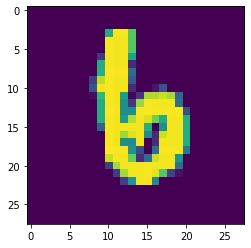

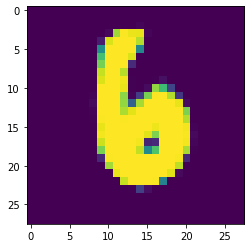

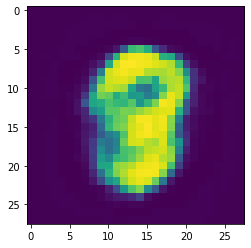

 78%|███████▊  | 183/235 [01:11<00:20,  2.57it/s]

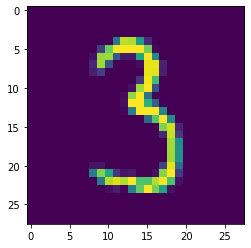

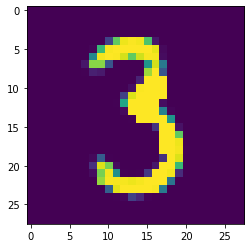

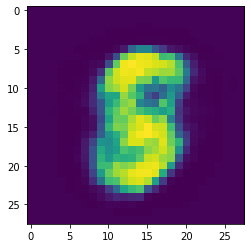

 78%|███████▊  | 184/235 [01:11<00:19,  2.60it/s]

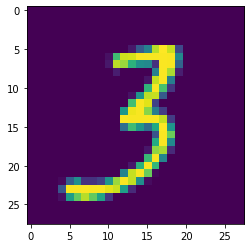

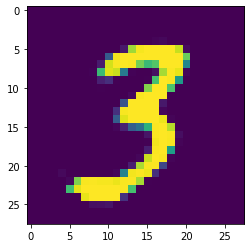

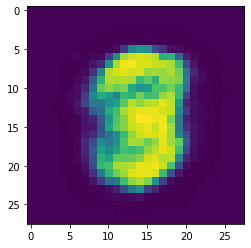

 79%|███████▊  | 185/235 [01:12<00:19,  2.61it/s]

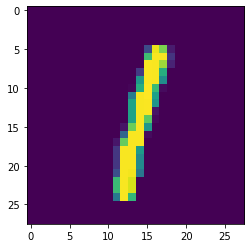

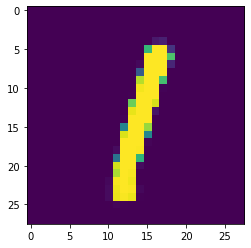

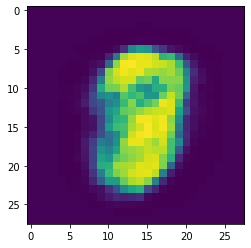

 79%|███████▉  | 186/235 [01:12<00:19,  2.55it/s]

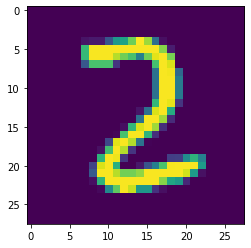

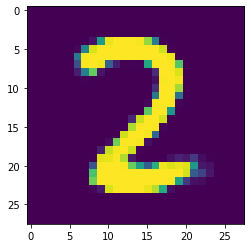

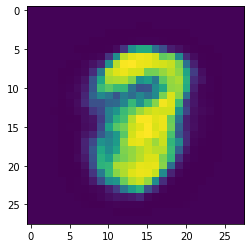

 80%|███████▉  | 187/235 [01:12<00:18,  2.58it/s]

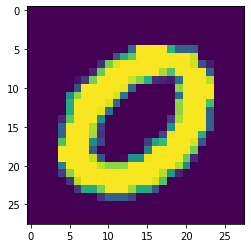

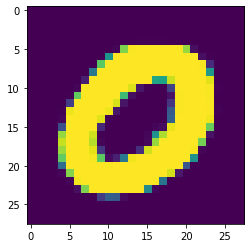

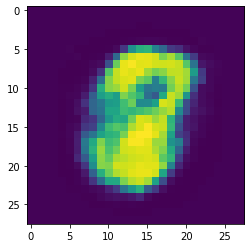

 80%|████████  | 188/235 [01:13<00:18,  2.60it/s]

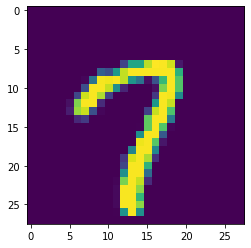

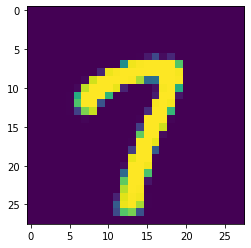

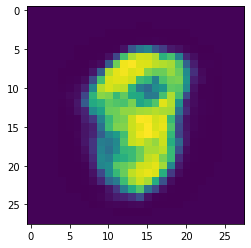

 80%|████████  | 189/235 [01:13<00:17,  2.62it/s]

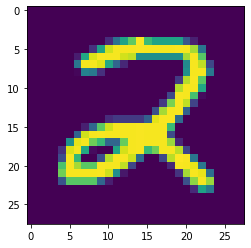

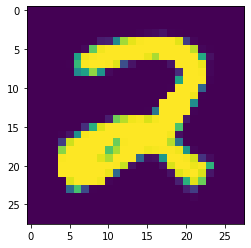

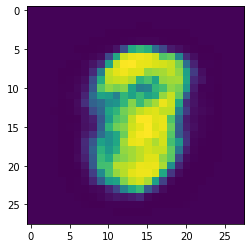

 81%|████████  | 190/235 [01:14<00:17,  2.55it/s]

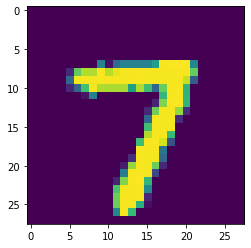

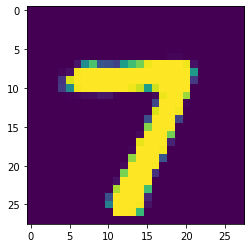

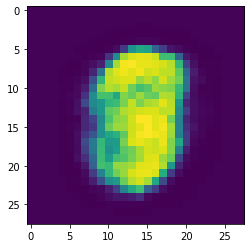

 81%|████████▏ | 191/235 [01:14<00:17,  2.58it/s]

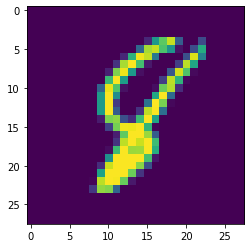

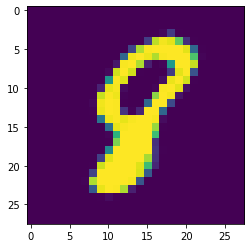

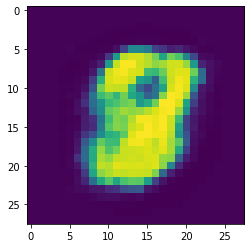

 82%|████████▏ | 192/235 [01:14<00:16,  2.60it/s]

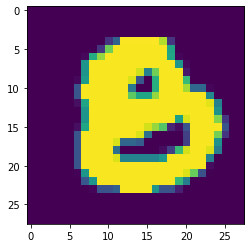

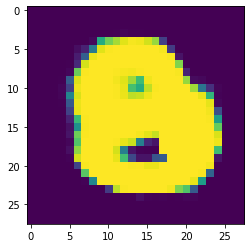

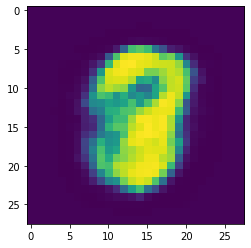

 82%|████████▏ | 193/235 [01:15<00:16,  2.62it/s]

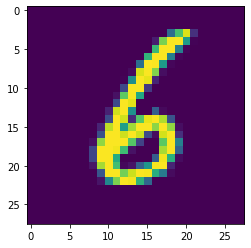

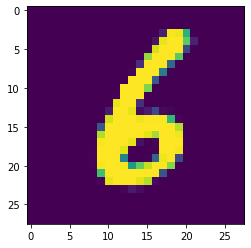

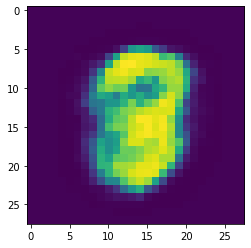

 83%|████████▎ | 194/235 [01:15<00:16,  2.55it/s]

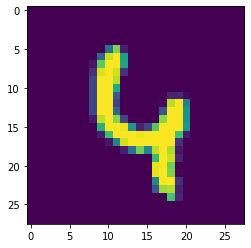

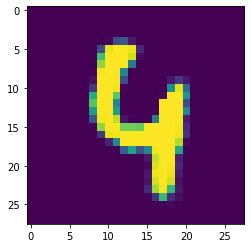

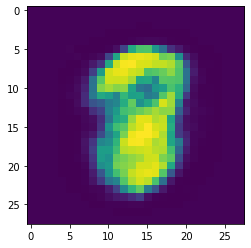

 83%|████████▎ | 195/235 [01:16<00:15,  2.58it/s]

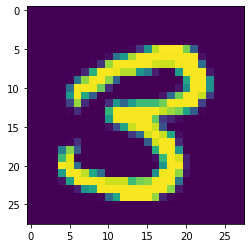

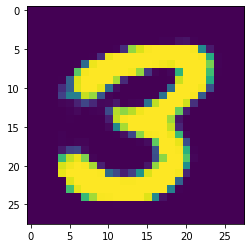

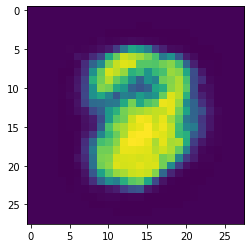

 83%|████████▎ | 196/235 [01:16<00:15,  2.60it/s]

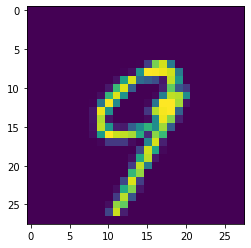

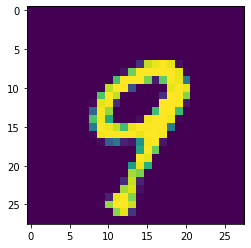

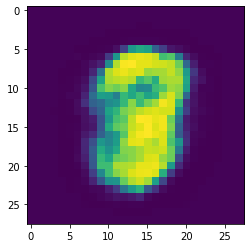

 84%|████████▍ | 197/235 [01:16<00:14,  2.62it/s]

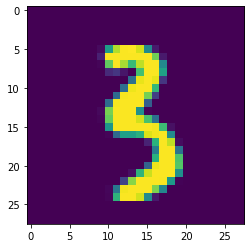

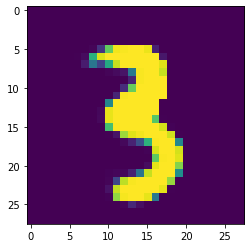

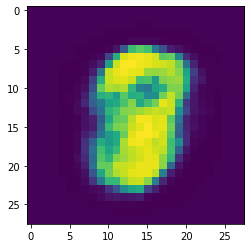

 84%|████████▍ | 198/235 [01:17<00:14,  2.55it/s]

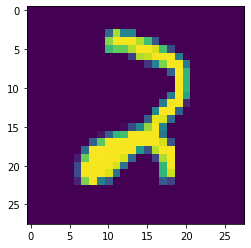

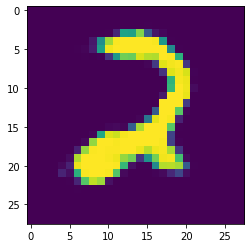

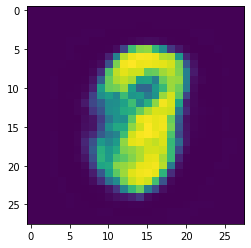

 85%|████████▍ | 199/235 [01:17<00:13,  2.58it/s]

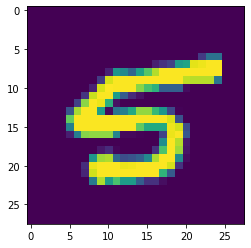

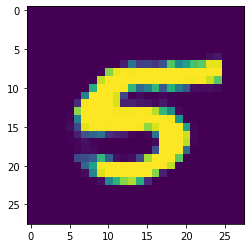

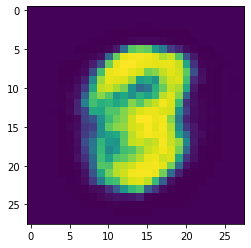

 85%|████████▌ | 200/235 [01:17<00:13,  2.60it/s]

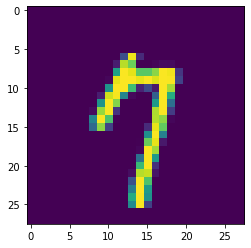

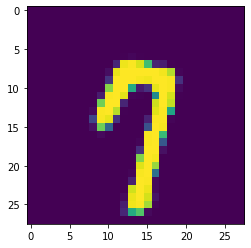

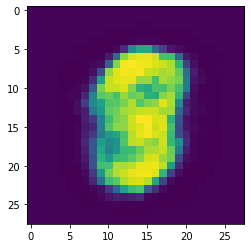

 86%|████████▌ | 201/235 [01:18<00:12,  2.62it/s]

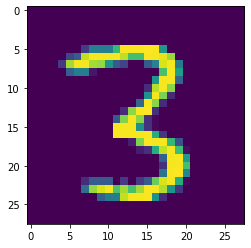

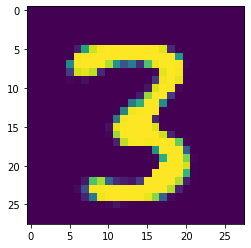

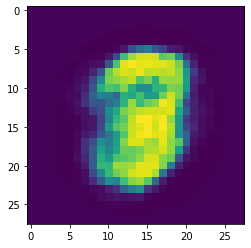

 86%|████████▌ | 202/235 [01:18<00:12,  2.55it/s]

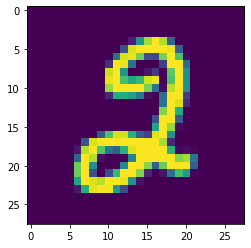

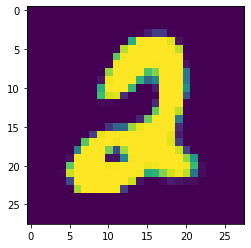

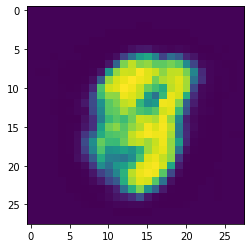

 86%|████████▋ | 203/235 [01:19<00:12,  2.58it/s]

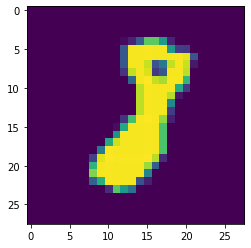

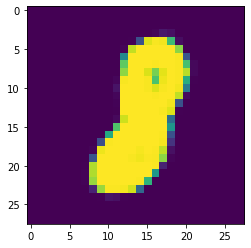

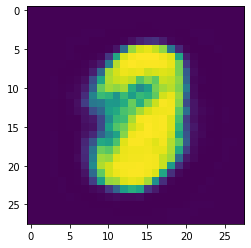

 87%|████████▋ | 204/235 [01:19<00:11,  2.60it/s]

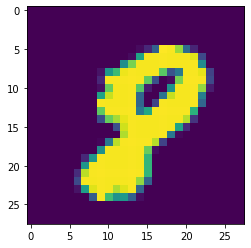

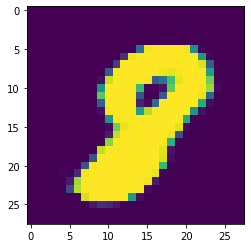

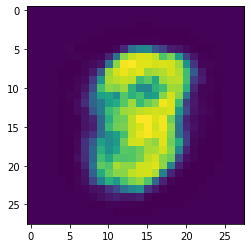

 87%|████████▋ | 205/235 [01:19<00:11,  2.62it/s]

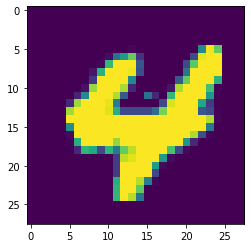

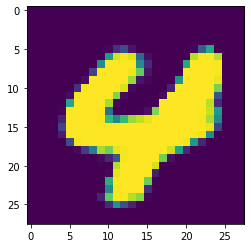

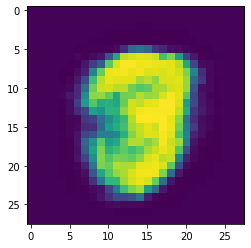

 88%|████████▊ | 206/235 [01:20<00:11,  2.55it/s]

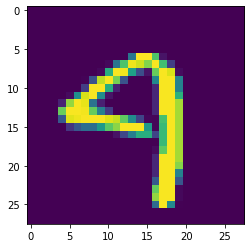

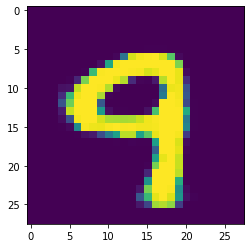

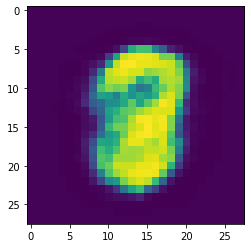

 88%|████████▊ | 207/235 [01:20<00:10,  2.58it/s]

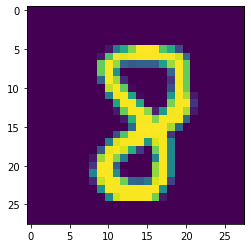

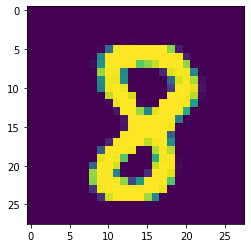

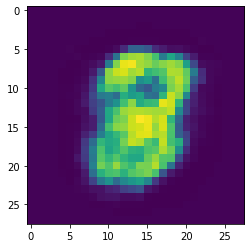

 89%|████████▊ | 208/235 [01:21<00:10,  2.60it/s]

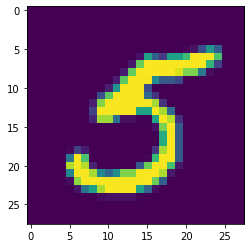

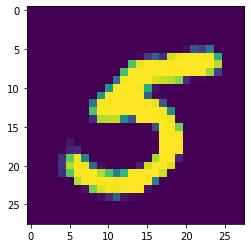

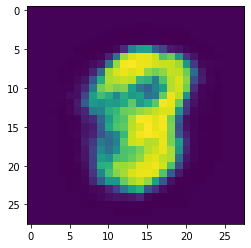

 89%|████████▉ | 209/235 [01:21<00:09,  2.62it/s]

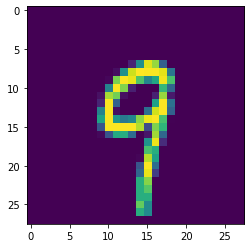

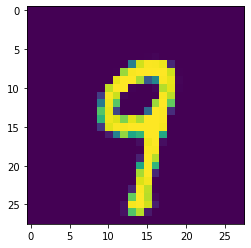

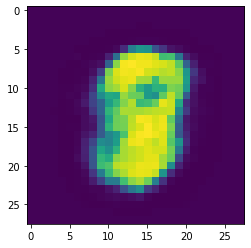

 89%|████████▉ | 210/235 [01:21<00:09,  2.55it/s]

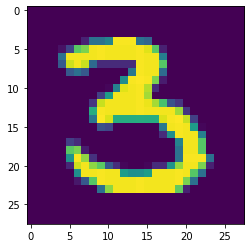

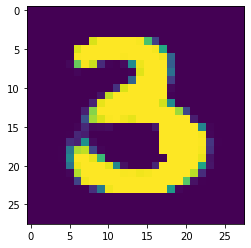

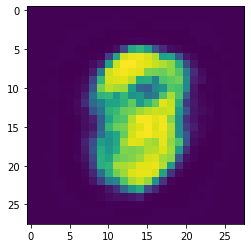

 90%|████████▉ | 211/235 [01:22<00:09,  2.58it/s]

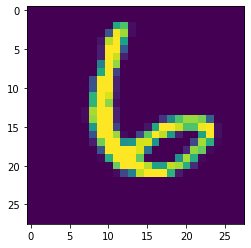

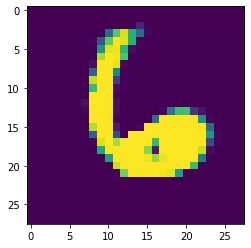

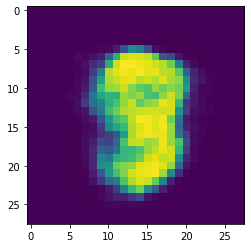

 90%|█████████ | 212/235 [01:22<00:08,  2.60it/s]

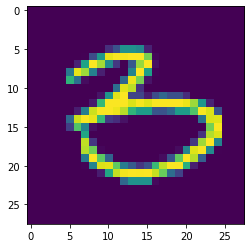

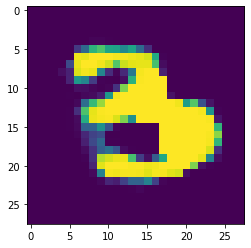

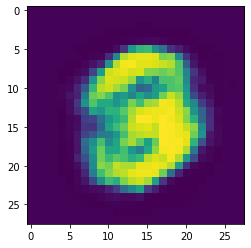

 91%|█████████ | 213/235 [01:23<00:08,  2.62it/s]

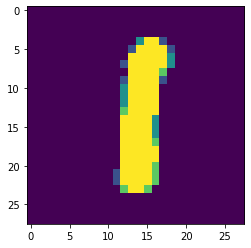

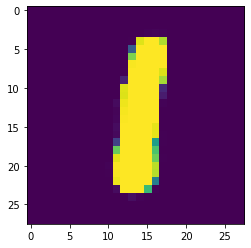

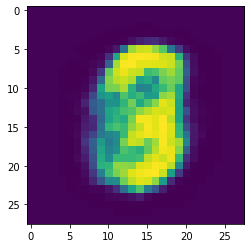

 91%|█████████ | 214/235 [01:23<00:08,  2.55it/s]

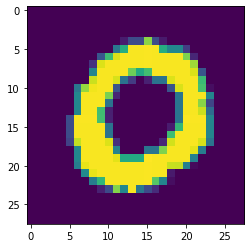

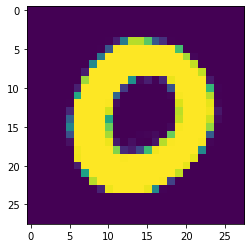

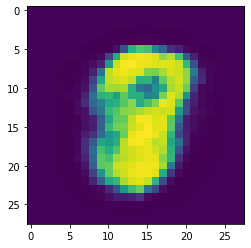

 91%|█████████▏| 215/235 [01:23<00:07,  2.58it/s]

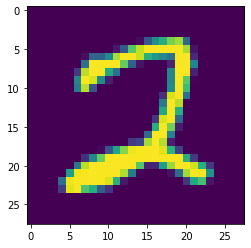

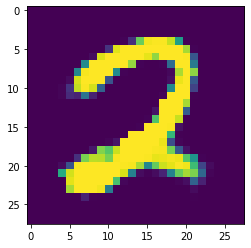

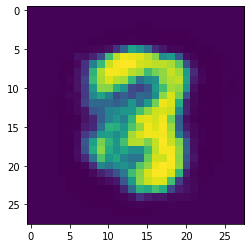

 92%|█████████▏| 216/235 [01:24<00:07,  2.60it/s]

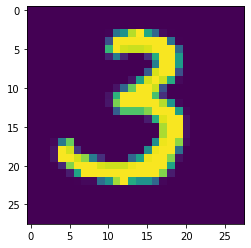

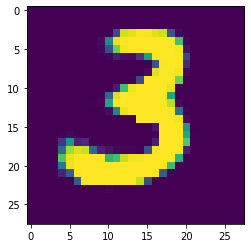

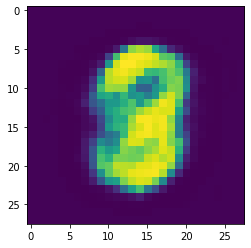

 92%|█████████▏| 217/235 [01:24<00:06,  2.62it/s]

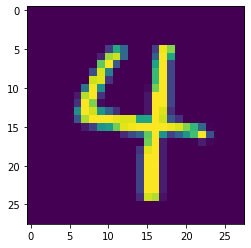

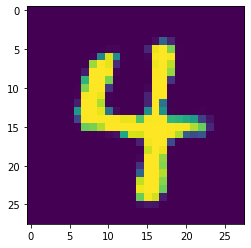

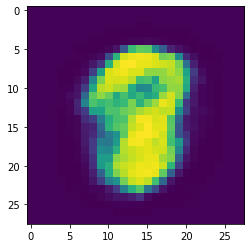

 93%|█████████▎| 218/235 [01:24<00:06,  2.55it/s]

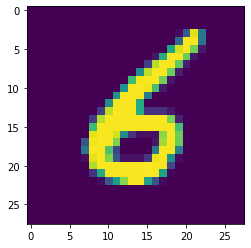

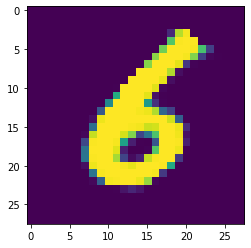

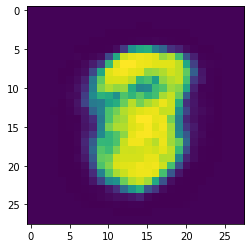

 93%|█████████▎| 219/235 [01:25<00:06,  2.58it/s]

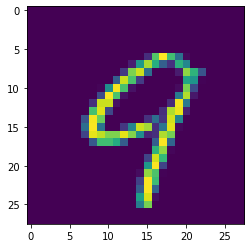

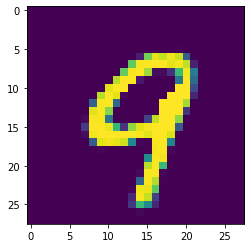

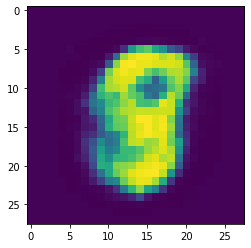

 94%|█████████▎| 220/235 [01:25<00:05,  2.60it/s]

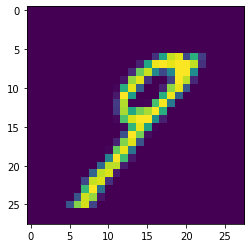

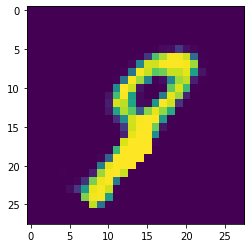

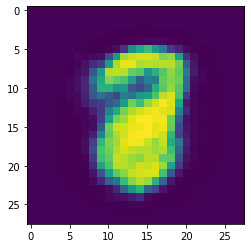

 94%|█████████▍| 221/235 [01:26<00:05,  2.62it/s]

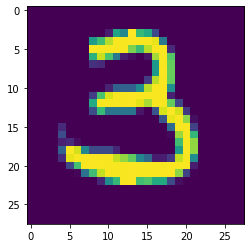

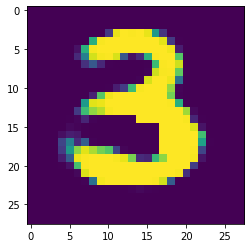

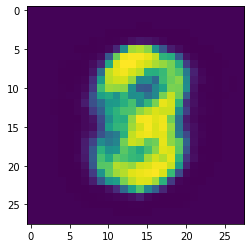

 94%|█████████▍| 222/235 [01:26<00:05,  2.55it/s]

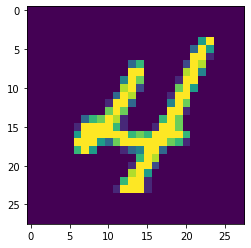

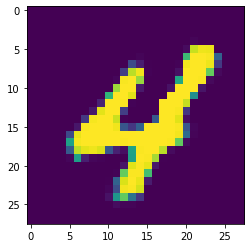

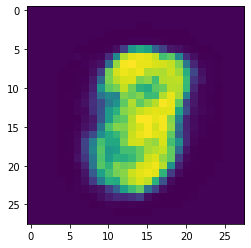

 95%|█████████▍| 223/235 [01:26<00:04,  2.58it/s]

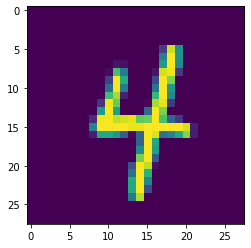

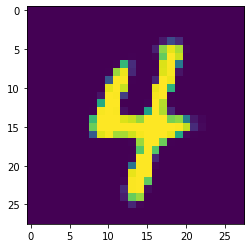

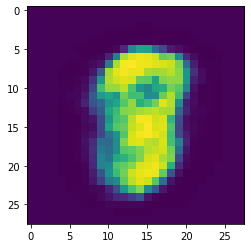

 95%|█████████▌| 224/235 [01:27<00:04,  2.60it/s]

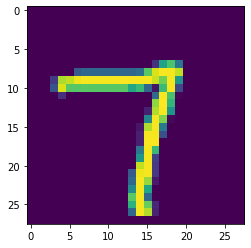

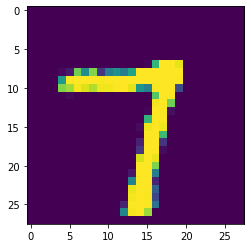

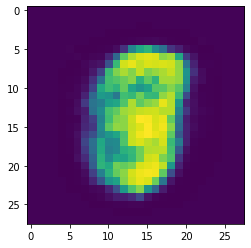

 96%|█████████▌| 225/235 [01:27<00:03,  2.62it/s]

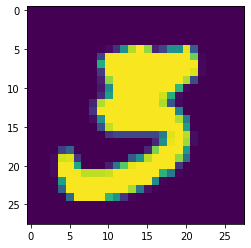

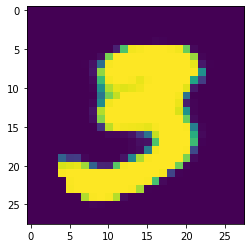

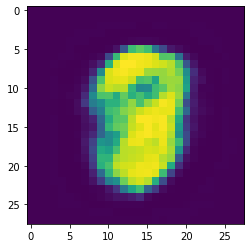

 96%|█████████▌| 226/235 [01:28<00:03,  2.55it/s]

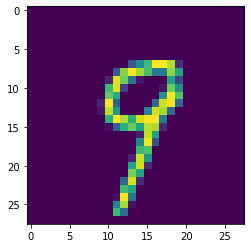

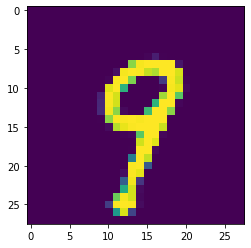

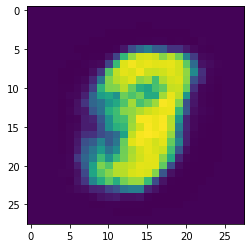

 97%|█████████▋| 227/235 [01:28<00:03,  2.58it/s]

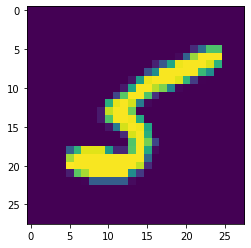

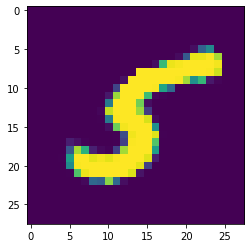

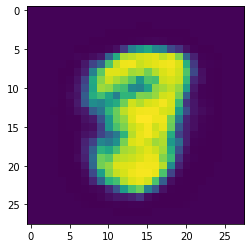

 97%|█████████▋| 228/235 [01:28<00:02,  2.59it/s]

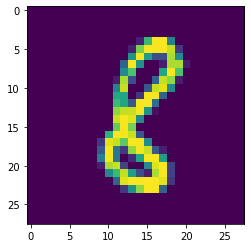

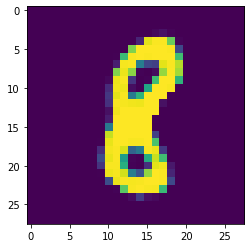

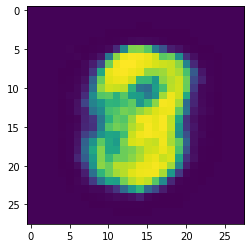

 97%|█████████▋| 229/235 [01:29<00:02,  2.61it/s]

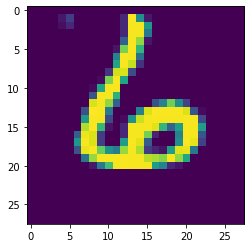

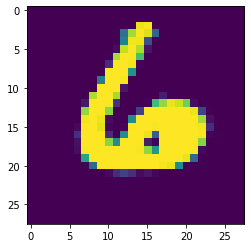

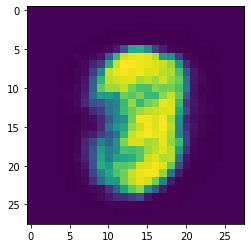

 98%|█████████▊| 230/235 [01:29<00:01,  2.55it/s]

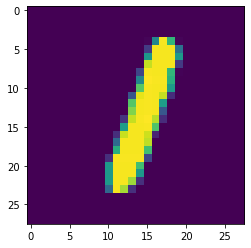

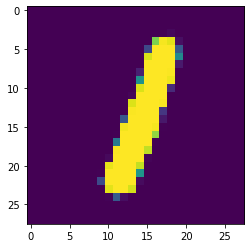

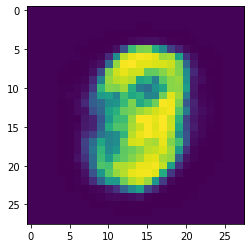

 98%|█████████▊| 231/235 [01:29<00:01,  2.57it/s]

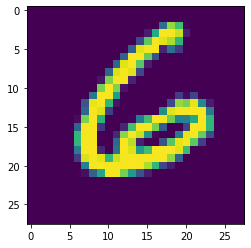

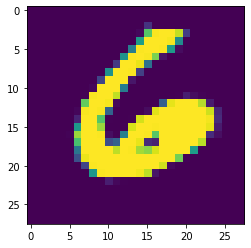

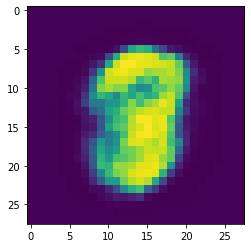

 99%|█████████▊| 232/235 [01:30<00:01,  2.59it/s]

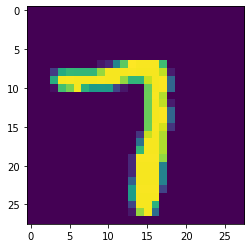

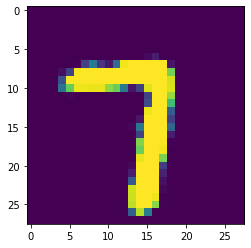

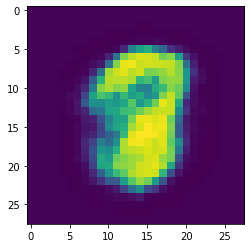

 99%|█████████▉| 233/235 [01:30<00:00,  2.61it/s]

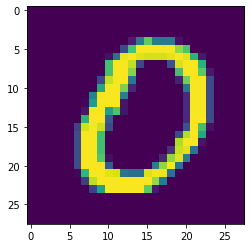

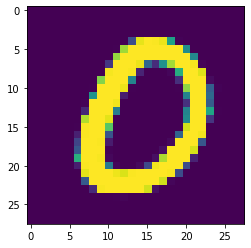

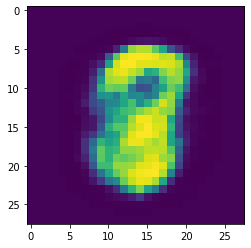

100%|█████████▉| 234/235 [01:31<00:00,  2.55it/s]

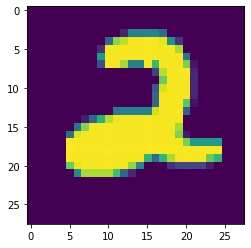

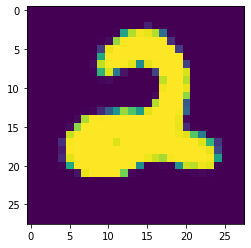

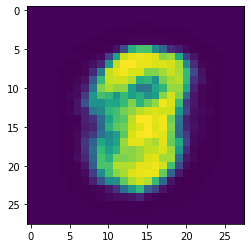

100%|██████████| 235/235 [01:31<00:00,  2.57it/s]


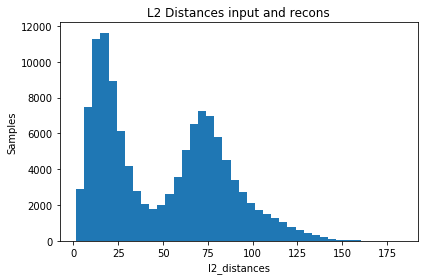

In [7]:
recon = Reconstructor(net)
l2_distances = L2_Cor_Incor_Capsules(net, recon, trainloader, args)
plot_hist(l2_distances, num_bins=40)

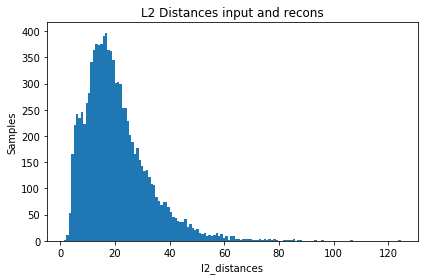

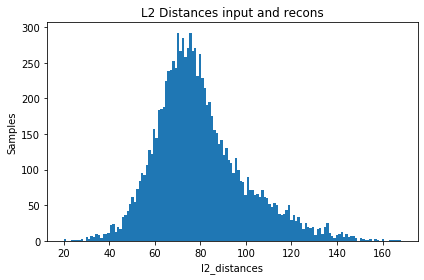

In [8]:
plot_hist(l2_distances[list(range(0,20000,2))], num_bins=140)
plot_hist(l2_distances[list(range(1,19999,2))], num_bins=140)

In [9]:
l2_distances[10:20]

array([ 3.9693766, 90.56902  , 31.911747 , 89.02602  , 41.9925   ,
       90.66319  , 57.37447  , 63.19472  , 18.982845 , 88.799484 ],
      dtype=float32)

In [12]:
l2_distances.shape

(20000,)

In [ ]:
# torch.save(capsule_net.state_dict(), "./CapsNetMNIST.pth")

In [7]:
for param in net.parameters():
    if(param.requires_grad==True):
        print(param.shape)

torch.Size([12, 1, 15, 15])
torch.Size([12])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 12, 8, 8])
torch.Size([1])
torch.Size([1, 49, 49, 16, 16])
torch.Size([1, 49, 10, 16, 16])
torch.Size([512, 160])
torch.Size([512])
torch.Size([1024, 512])
torch.Size([1024])
torch.Size([784, 1024])
torch.Size([784])


In [3]:
!nvidia-smi

Wed Oct 21 18:55:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TITAN   Off  | 00000000:02:00.0 Off |                  N/A |
| 46%   68C    P0    71W / 250W |    276MiB /  6081MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TITAN   Off  | 00000000:04:00.0 Off |                  N/A |
| 36%   

In [ ]:
#Config for 16 1d vectors in Capsule Layer. Set the Softmax Dimension to 1 in this case
# class Config:
#     def __init__(self, dataset='mnist'):
#         # CNN (cnn)
#         self.cnn_in_channels = 1
#         self.cnn_out_channels = 12
#         self.cnn_kernel_size = 15

#         # Primary Capsule (pc)
#         self.pc_num_capsules = 1
#         self.pc_in_channels = 12
#         self.pc_out_channels = 16
#         self.pc_kernel_size = 8
#         self.pc_num_routes = 16 * 7 * 7

#         # Digit Capsule 1 (dc)
#         self.dc_num_capsules = 49
#         self.dc_num_routes = 16 * 7 * 7
#         self.dc_in_channels = 1
#         self.dc_out_channels = 1 #16
        
#         # Digit Capsule 2 (dc)
#         self.dc_2_num_capsules = 10
#         self.dc_2_num_routes = 7 * 7
#         self.dc_2_in_channels = 1 #16
#         self.dc_2_out_channels = 16

#         # Decoder
#         self.input_width = 28
#         self.input_height = 28